In [5]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
import pandas as pd
import os
import sys
import seaborn as sns

# Get notebook and parent dir
current_dir = os.path.dirname(os.path.abspath('__file__')) 
parent_dir = os.path.dirname(current_dir)

# Set path to pedophysics module 
pedophysics_code_path = os.path.join(parent_dir)
sys.path.insert(0, pedophysics_code_path)

from pedophysics import predict, Soil
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.optimize import root
from scipy.stats import spearmanr
from IPython.display import clear_output

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from PyPDF2 import PdfMerger

# Electromagnetic induction data inversion package
from plots import *
from PM import *
%matplotlib inline

pd.set_option('display.max_columns', None)
from utils.spatial_utils import get_coincident

pd.option_context('mode.use_inf_as_na', True)


### Results plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


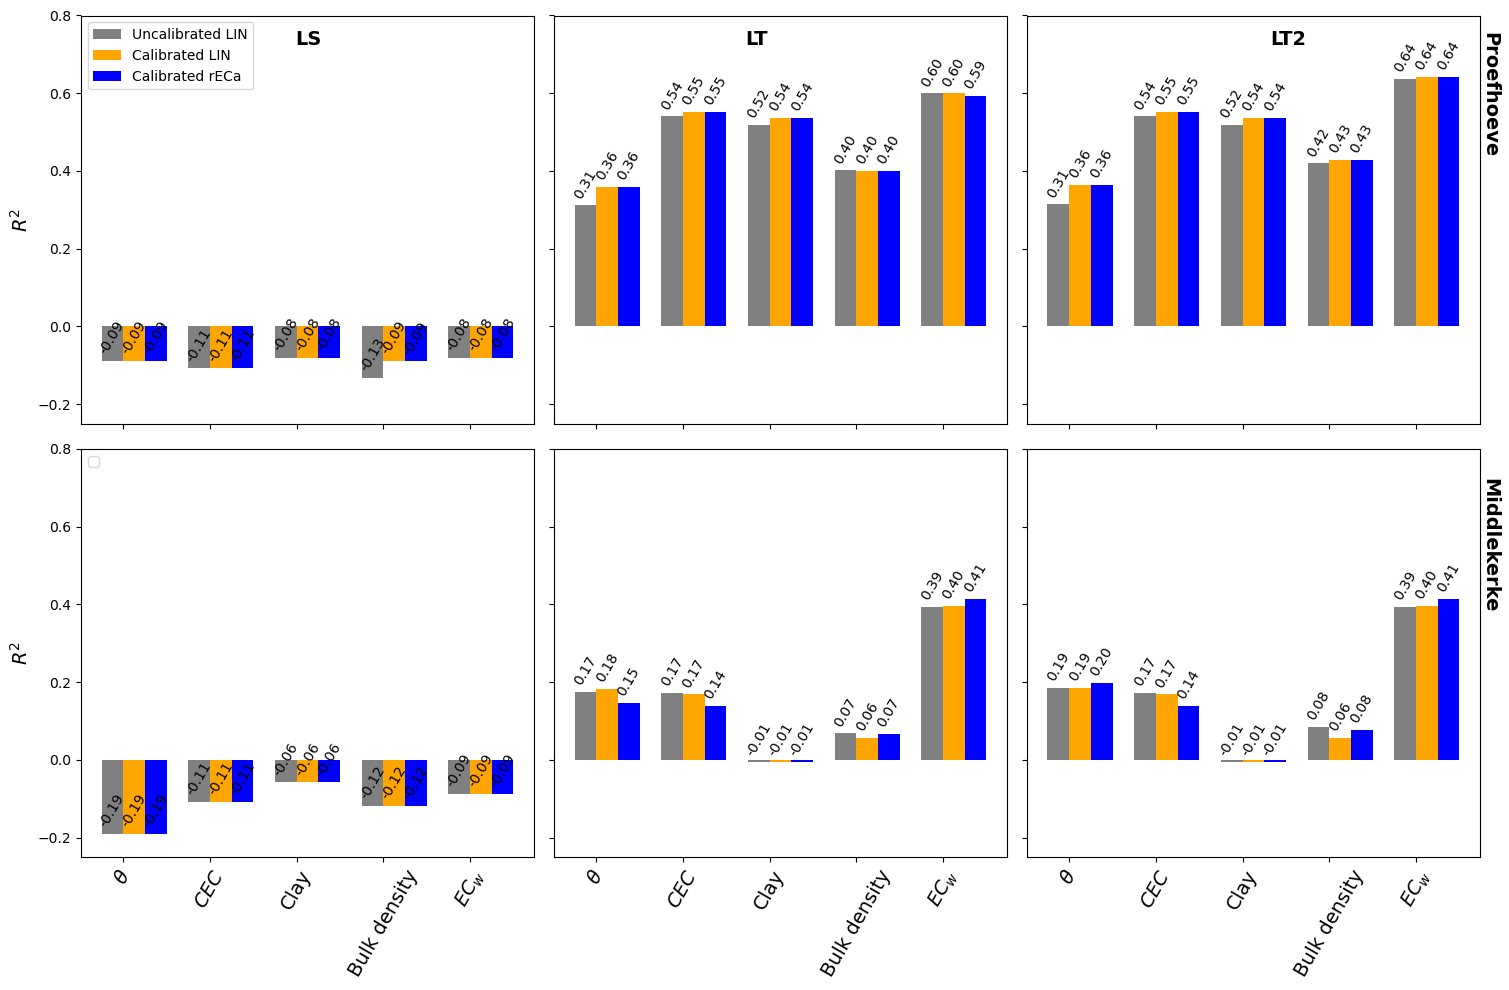

In [6]:
uncal_LIN_P = pd.read_excel('output_tables/'+'SR2_results'+'_'+'P'+'_'+'LIN'+'_'+'non_calibrated'+'_'+'21HS'+'.xlsx')
cal_LIN_P = pd.read_excel('output_tables/'+'SR2_results'+'_'+'P'+'_'+'LIN'+'_'+'calibrated'+'_'+'21HS'+'.xlsx')
cal_rECa_P = pd.read_excel('output_tables/'+'SR2_results'+'_'+'P'+'_'+'reca'+'_'+'calibrated'+'_'+'21HS'+'.xlsx')

uncal_LIN_M = pd.read_excel('output_tables/'+'SR2_results'+'_'+'M'+'_'+'LIN'+'_'+'non_calibrated'+'_'+'421S'+'.xlsx')
cal_LIN_M = pd.read_excel('output_tables/'+'SR2_results'+'_'+'M'+'_'+'LIN'+'_'+'calibrated'+'_'+'421S'+'.xlsx')
cal_rECa_M = pd.read_excel('output_tables/'+'SR2_results'+'_'+'M'+'_'+'reca'+'_'+'calibrated'+'_'+'421S'+'.xlsx')

target_set = [
    '${θ}$',
    '${CEC}$',
    'Clay',
    'Bulk density',
    '${EC_w}$']

approaches = ['LT', 'LS', 'LS2']


plot_bars(uncal_LIN_M, cal_LIN_M, cal_rECa_M, uncal_LIN_P, cal_LIN_P, cal_rECa_P, target_set, approaches)

# Configure input

In [23]:
s_site = 'M'

# Parameters
cl = 0.3       # 0.2, 0.3, 0.4
percent = 20   # 10, 20, 30
# Inversion parameters
FM = 'FSeq' #'CS', 'FSlin' or 'FSeq'
MinM = 'Gauss-Newton'  
alpha = 0.07
remove_coil = False
start_avg = True
constrain = False

## Load data

In [24]:
datafolder = 'data' # data folder
data_inv_folder = 'data/inverted'
data_sanalysis_folder = 'data/soil_analyses'

if s_site == 'P':
    profile_prefix = 'proefhoeve'
    emfile_prefix = 'proefhoeve_21HS'
    #else: 
    #    emfile_prefix = 'proefhoeve_421S'
else:
    profile_prefix = 'middelkerke'
    emfile_prefix = 'middelkerke_421S'

inv_s = os.path.join(data_inv_folder, f'{emfile_prefix}_inverted_samples_{cl}_{percent}_{FM}_{MinM}_{alpha}_{remove_coil}_{start_avg}_{constrain}.csv')

# Define input datatype and source folder
em_intype = 'reca'   # 'reca', 'LIN' 
cal = 'calibrated' # 'calibrated', 'non_calibrated', 'drift_calibrated'

if cal == 'non_calibrated':
    em_intype = 'LIN' 
    
instrument_code = '21HS' # 421S, '21HS'

if s_site == 'M':
    instrument_code = '421S'

cal_folder = os.path.join(datafolder, cal)
em_survey = os.path.join(cal_folder, f'{emfile_prefix}_raw_calibrated_rECa_{cl}_{percent}.csv')
sampleprop = os.path.join(data_sanalysis_folder, f'{profile_prefix}_soil_analysis.csv')

# Profile smoothing parameters 
window_size = 1 # Define your window size for simple moving average filter (1 = no filtering)

# 1.0 Data import and structuring into dataframe
em_survey = pd.read_csv(em_survey, sep=',', header=0)
print('em_survey', em_survey.head())

inverted = pd.read_csv(inv_s, sep=',', header=0)
samples_analysis = pd.read_csv(sampleprop, sep=',', header=0)
print('samples', samples_analysis.head())

em_sample_prop = get_coincident(em_survey, samples_analysis)

# Data import dry down experiment
#dry_down = os.path.join(datafolder, f'Dry_down.csv')
#dry_d = pd.read_csv(dry_down, sep=',', header=0)

em_survey               x              y  Unnamed: 0         z         t      HCP1QP  \
0  41563.154018  204149.165138           0  0.358554  45474.80  184.070852   
1  41563.153086  204149.166916           1  0.358554  45475.00  184.070852   
2  41563.151941  204149.169099           2  0.358554  45475.17  184.070852   
3  41563.150230  204149.172361           3  0.358554  45475.38  184.070852   
4  41563.148435  204149.175784           4  0.358554  45475.58  184.070852   

      PRP1QP      HCP2QP      PRP2QP      HCP4QP      PRP4QP  HCP1IP  PRP1IP  \
0  86.260687  272.098482  154.412369  390.001711  246.907435    2.01    0.04   
1  86.260687  272.098482  154.412369  390.327538  246.017590    2.01    0.04   
2  86.260687  272.098482  154.412369  391.960358  246.017590    2.01    0.04   
3  86.260687  272.098482  154.412369  390.653769  246.017590    2.01    0.04   
4  86.260687  272.098482  154.412369  389.350660  245.661752    2.01    0.04   

   HCP2IP  PRP2IP  HCP4IP  PRP4IP  \
0  

# Data Analysis
### Data wrangling

In [25]:
#pd.options.future.infer_string = True
ds = em_sample_prop.copy()

# Caclculate Bulk EC from HydraProbe data at 50Mhz
offset = 4
water_perm = 80
ds['bulk_ec_hp'] = logsdon(50e6, ds.rperm, ds.iperm)

# DRY DOWN experiment
#dry_d['P_top_EC'] = logsdon(50e6, dry_d.P_top_RP, dry_d.P_top_IP)
#dry_d['P_bot_EC'] = logsdon(50e6, dry_d.P_bot_RP, dry_d.P_bot_IP)
#dry_d['M_top_EC'] = logsdon(50e6, dry_d.M_top_RP, dry_d.M_top_IP)
#dry_d['M_bot_EC'] = logsdon(50e6, dry_d.M_bot_RP, dry_d.M_bot_IP)

#dry_d['P_top_ECw'] = predict.WaterEC(Soil(bulk_ec_dc = dry_d.P_top_EC.values,
#                                          water = dry_d.P_top_W.values,
#                                          temperature = dry_d.P_top_T.values+273.15))

#dry_d['P_bot_ECw'] = predict.WaterEC(Soil(bulk_ec_dc = dry_d.P_bot_EC.values,
#                                          water = dry_d.P_bot_W.values,
#                                          temperature = dry_d.P_bot_T.values+273.15))

#dry_d['M_top_ECw'] = predict.WaterEC(Soil(bulk_ec_dc = dry_d.M_top_EC.values,
#                                          water = dry_d.M_top_W.values,
#                                          temperature = dry_d.M_top_T.values+273.15))

#dry_d['M_bot_ECw'] = predict.WaterEC(Soil(bulk_ec_dc = dry_d.M_bot_EC.values,
#                                          water = dry_d.M_bot_W.values,
#                                          temperature = dry_d.M_bot_T.values+273.15))

#if profile_prefix == 'proefhoeve':
#    water_ec_10cm = dry_d.P_top_ECw.values[0]
#    water_ec_50cm = dry_d.P_bot_ECw.values[0]
#    water_ec_mean = (water_ec_10cm + water_ec_50cm)/2

#elif profile_prefix == 'middelkerke':
#    water_ec_10cm = dry_d.M_top_ECw.values[0]
#    water_ec_50cm = dry_d.M_bot_ECw.values[0]
#    water_ec_mean = (water_ec_10cm + water_ec_50cm)/2

###################

ds['bulk_ec_dc_hp'] = predict.BulkECDC(Soil(frequency_ec = 50e6,
                                              bulk_ec = ds.bulk_ec_hp.values))

ds['bulk_ec_tc_hp'] = SheetsHendrickxEC( ds.bulk_ec_hp, ds.temp)
ds['bulk_ec_dc_tc_hp'] = predict.BulkECDCTC(Soil(temperature = ds.temp.values,
                                                    bulk_ec_dc = ds.bulk_ec_dc_hp.values
                                                    ))

# Caclculate Water EC from HydraProbe data at 50Mhz
ds['water_ec_hp'] = Hilhorst(ds.bulk_ec_hp, ds.rperm, water_perm, offset)
ds['water_ec_hp_t'] = WraithOr(ds.water_ec_hp, ds.temp)
ds['iperm_water_t'] = ds.water_ec_hp_t/(50e6*2*pi*epsilon_0)

ds.head() # 0.121972	0.15213	0.124956	0.140491

,x,y,Unnamed: 0,z,t,HCP1QP,PRP1QP,HCP2QP,PRP2QP,HCP4QP,PRP4QP,HCP1IP,PRP1IP,HCP2IP,PRP2IP,HCP4IP,PRP4IP,geometry,code,x_clhs,y_clhs,z,t,depth,humus,pH_eau,CEC,clay,silt,sand,caCO,TOC,bd,vwc,copeky,temp,rperm,iperm,bulk_ec_hp,bulk_ec_dc_hp,bulk_ec_tc_hp,bulk_ec_dc_tc_hp,water_ec_hp,water_ec_hp_t,iperm_water_t
5707,41564.535077,204206.635045,5707,0.550000,46700.42,150.246774,73.289990,222.269962,112.665316,354.580939,186.682172,2.04,0.13,7.76,0.63,37.08,4.53,POINT (487360.74572300375 5665157.524426416),1,41565.381,204207.342,0,0,10,2.516,7.84,20.725,22.106,65.499,12.396,0.0,12.58,1.281,0.26224,13,32.7,10.7,10.3,0.016247,0.00368,0.013997,40.491499,0.193993,0.166944,60.016810
11480,41548.703506,204311.609252,11480,0.849275,48080.26,134.668820,112.802070,148.821194,107.639367,219.211364,120.501385,1.86,0.07,5.91,0.16,28.12,4.28,POINT (487342.9922624455 5665262.147642509),2,41549.211,204310.992,0,0,10,1.162,8.32,20.482,25.616,59.907,14.477,2.1,8.27,1.403,0.41344,20,31.1,28.1,35.1,0.046509,0.02260,0.041255,263.959305,0.154387,0.136948,49.233106
6927,41589.686457,204167.815631,6927,0.550000,46944.42,190.342979,94.623589,275.732159,158.660755,396.563075,249.757347,2.16,0.10,8.15,0.93,39.79,7.78,POINT (487386.5968327209 5665119.18975482),3,41588.221,204167.503,0,0,10,2.714,8.32,23.113,24.670,66.901,8.430,4.0,18.31,1.386,0.30754,22,28.3,8.7,6.4,0.011783,0.00186,0.011023,24.115069,0.200569,0.187797,67.513397
25046,41668.920118,204238.288792,25046,0.450000,53527.92,180.940690,93.758316,268.675812,156.637411,382.569639,249.044525,2.21,0.21,8.25,0.79,38.92,7.47,POINT (487464.4890758196 5665191.080228904),4,41668.451,204238.440,0,0,10,1.622,8.17,24.345,27.206,66.315,6.478,1.7,10.14,1.279,0.32295,24,31.6,16.7,18.5,0.026637,0.00991,0.023411,113.606853,0.167790,0.147428,53.000782
8518,41521.645924,204334.581486,8518,0.850000,47262.62,207.473761,167.425834,251.695428,187.857975,323.924383,233.951110,1.96,0.13,6.65,0.66,32.71,8.17,POINT (487315.5275392472 5665284.609093723),5,41520.385,204334.195,0,0,10,1.686,8.18,20.992,26.516,58.833,14.650,2.4,11.35,1.413,0.41837,7,26.2,17.6,20.7,0.028611,0.01114,0.027903,156.196437,0.168299,0.164272,59.056121


In [26]:
inv_columns = inverted.columns[3:-1]
ds[inv_columns] = np.nan

for idc, c in enumerate(inv_columns):

    for i in range(len(inverted.x)):
        ds.loc[ds.code == i+1, c] = inverted.loc[i, c]

def closest_ec(row):
    depth = row['depth']
    # Filter columns that start with 'EC_' but not 'EC_end'
    ec_cols = [col for col in row.index if col.startswith('EC_') and col != 'EC_end']
    # Convert the part after 'EC_' to float and calculate the absolute difference with depth
    differences = {col: abs(depth/100 - float(col.split('_')[1])) for col in ec_cols}
    # Find the column name with the minimum difference
    closest_col = min(differences, key=differences.get)
    return row[closest_col]

print(ds.head())

# Apply the function to each row
ds['bulk_ec_inv'] = ds.apply(closest_ec, axis=1)

ds['bulk_ec_dc_tc_inv'] = predict.BulkECDCTC(Soil(temperature = ds.temp.values+273.15,
                                                      frequency_ec = 9e3,
                                                      bulk_ec = ds.bulk_ec_inv.values/1000))*1000


ds['ideal_bulk_ec'] = predict.BulkEC(
                                        Soil(temperature = ds.temp.values+273.15,
                                             water = ds.vwc.values,
                                             clay = ds.clay.values,
                                             bulk_density = ds.bd.values,
                                             water_ec = ds.water_ec_hp.values,
                                             frequency_ec = 9e3
                                            )

)

if instrument_code == '21HS':
    feature_set = [
        'HCPHQP',
        'HCP1QP',
        'HCP2QP',
        'PRPHQP',
        'PRP1QP',
        'PRP2QP',
        'bulk_ec_inv',
    #    'bulk_ec_dc_tc_inv',
    #    'bulk_ec_hp',
    #    'bulk_ec_dc_tc_hp'
    ]
elif instrument_code == '421S':
    feature_set = [
        'HCP1QP',
        'HCP2QP',
        'HCP4QP',
        'PRP1QP',
        'PRP2QP',
        'PRP4QP',
        'bulk_ec_inv',
    #    'bulk_ec_dc_tc_inv',
    #    'bulk_ec_hp',
    #    'bulk_ec_dc_tc_hp'
    ]
    
folder_path = 'output_tables/'
file_name = 'ds_'+profile_prefix+'.csv'
ds.to_csv(folder_path + file_name, index=False)


                  x              y  Unnamed: 0         z         t  \
5707   41564.535077  204206.635045        5707  0.550000  46700.42   
11480  41548.703506  204311.609252       11480  0.849275  48080.26   
6927   41589.686457  204167.815631        6927  0.550000  46944.42   
25046  41668.920118  204238.288792       25046  0.450000  53527.92   
8518   41521.645924  204334.581486        8518  0.850000  47262.62   

           HCP1QP      PRP1QP      HCP2QP      PRP2QP      HCP4QP      PRP4QP  \
5707   150.246774   73.289990  222.269962  112.665316  354.580939  186.682172   
11480  134.668820  112.802070  148.821194  107.639367  219.211364  120.501385   
6927   190.342979   94.623589  275.732159  158.660755  396.563075  249.757347   
25046  180.940690   93.758316  268.675812  156.637411  382.569639  249.044525   
8518   207.473761  167.425834  251.695428  187.857975  323.924383  233.951110   

       HCP1IP  PRP1IP  HCP2IP  PRP2IP  HCP4IP  PRP4IP  \
5707     2.04    0.13    7.76    0.

### Correlations

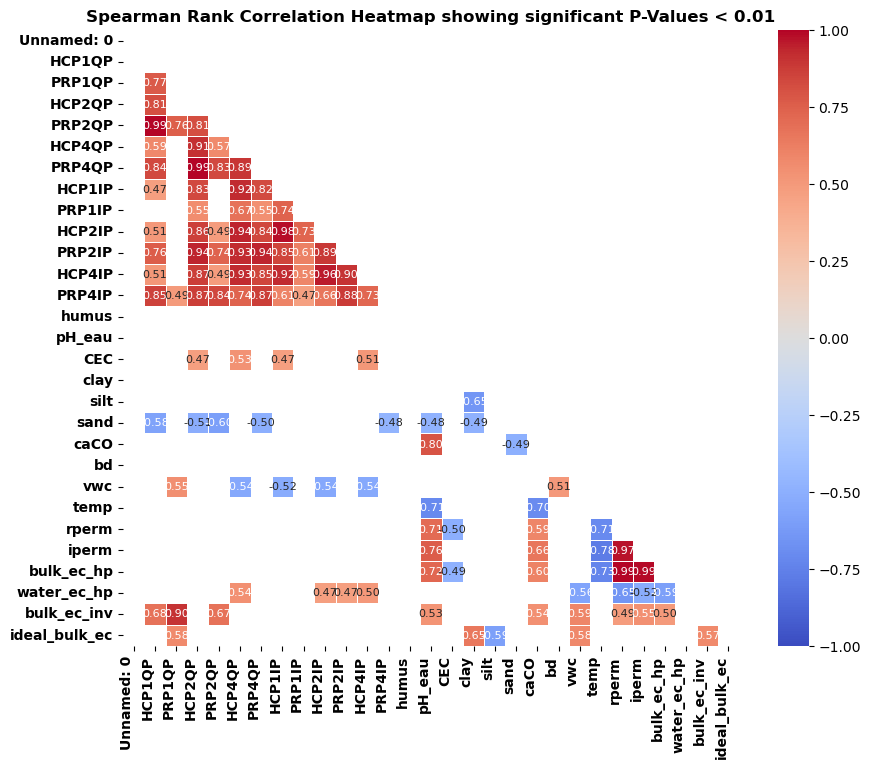

In [27]:
filtered_features = ['x', 'y', 'z', 't', 'geometry', 'code', 'TOC', 'x_clhs', 'y_clhs', 'depth', 'copeky', 'bulk_ec_dc_hp', 'bulk_ec_tc_hp', 'bulk_ec_dc_tc_hp', 'water_ec_hp_t', 'iperm_water_t', 'bulk_ec_dc_tc_inv']

# Filter out columns that start with 'EC_' and are not constant
non_ec_columns = [col for col in ds.columns if col not in filtered_features and not col.startswith('EC_') and not col.endswith('_inph')]

# Calculate the Spearman rank correlation coefficients and p-values
corr, p_value = spearmanr(ds[non_ec_columns], nan_policy='omit')

# Convert to DataFrame for easier plotting
corr_df = pd.DataFrame(corr, index=non_ec_columns, columns=non_ec_columns)
p_value_df = pd.DataFrame(p_value, index=non_ec_columns, columns=non_ec_columns)

# Create a mask for significant p-values (e.g., p < 0.01)
p_value_mask = 0.01
significant_mask = p_value_df < p_value_mask

# Mask for the upper triangle
mask = np.triu(np.ones_like(corr_df, dtype=bool))

# Combine the masks
final_mask = mask | ~significant_mask

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_df, mask=final_mask, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, vmin=-1, vmax=1, annot_kws={"size": 8})

# Adjust layout for better readability
plt.xticks(rotation=90, ha='right', fontsize=10, fontweight='bold')
plt.yticks(rotation=0, fontsize=10, fontweight='bold')
plt.title('Spearman Rank Correlation Heatmap showing significant P-Values < '+str(p_value_mask), fontsize=12, fontweight='bold')

# Show the plot

folder_path = 'output_images/'
filename = f"Corr_{s_site}_{cal}_{em_intype}.pdf"
plt.savefig(folder_path + filename)
plt.show()




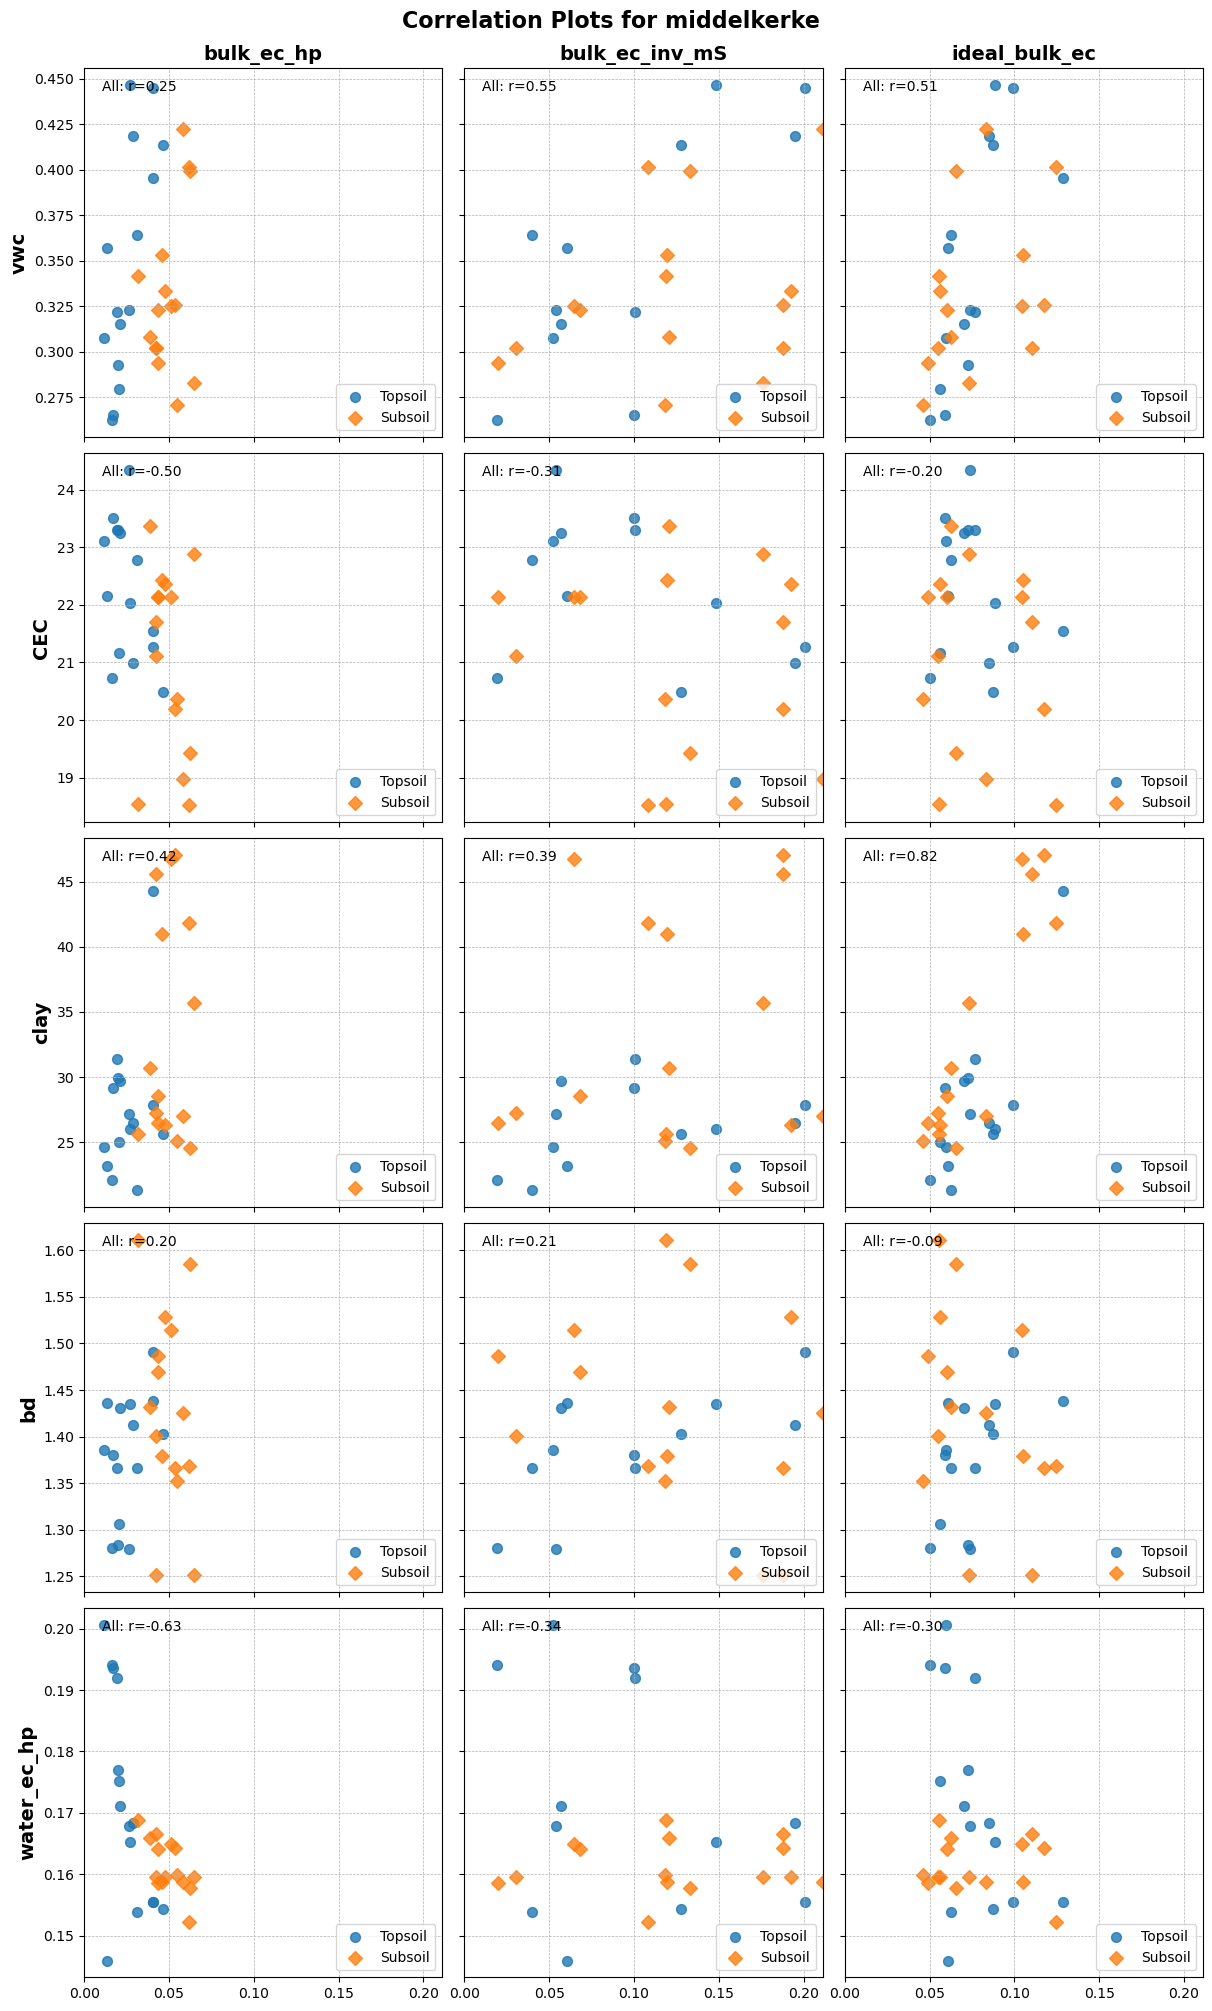

In [28]:
target_set = [
    'vwc',
    'CEC',
    'clay',
    'bd',
    'water_ec_hp'
]

fig, axes = plt.subplots(5, 3, figsize=(12, 20))
ss = 50  # Reduced size for scatter points

ds['bulk_ec_inv_mS'] = ds.bulk_ec_inv/1000
preds = ['bulk_ec_hp', 'bulk_ec_inv_mS', 'ideal_bulk_ec']

def corr_plot(df, preds, targets):
    global_max_x = float('-inf')

    for target_index, target in enumerate(targets):
        for pred_index, pred in enumerate(preds):
            ax = axes[target_index, pred_index]
            ax.grid(True, which='both', linestyle='--', linewidth=0.5)
            #ax.set_aspect('equal')  # Ensure each subplot is square

            # General correlation coefficient
            general_corr = np.corrcoef(df[pred].dropna(), df[target].dropna())[0, 1]
            ax.text(0.05, 0.95, f'All: r={general_corr:.2f}', transform=ax.transAxes, va="center")

            for layer_cm in [10, 50]:
                x_data = df[df['depth'] == layer_cm][pred]
                y_data = df[df['depth'] == layer_cm][target]
                
                label = 'Topsoil' if layer_cm == 10 else 'Subsoil'
                ax.scatter(x_data, y_data, s=ss, alpha=0.8, marker='o' if layer_cm == 10 else 'D', label=label)

            if target_index == 0:
                ax.set_title(pred, fontweight='bold', fontsize=14)
            if target_index != len(targets) - 1:
                ax.set_xticklabels([])
            if pred_index == 0:
                ax.set_ylabel(target, fontweight='bold', fontsize=14)
            if pred_index != 0:
                ax.set_yticklabels([])

            # Update global max x value
            global_max_x = max(global_max_x, x_data.max())

            ax.legend(loc='lower right')  # Add the legend in the lower right corner

    # Set the same x-axis limits for all subplots
    for ax_row in axes:
        for ax in ax_row:
            ax.set_xlim(0, global_max_x)

corr_plot(ds, preds, target_set)

plt.subplots_adjust(top=0.7)  # You can adjust this value as needed
plt.suptitle(f"Correlation Plots for {profile_prefix}", fontweight='bold', fontsize=16, y=0.999)  # Adjust y as needed
plt.tight_layout(pad=0.5, w_pad=0.4, h_pad=0.8)

folder_path = 'output_images/'
filename = f"Plot_{s_site}.pdf"
plt.savefig(folder_path + filename, dpi=300)
plt.show()

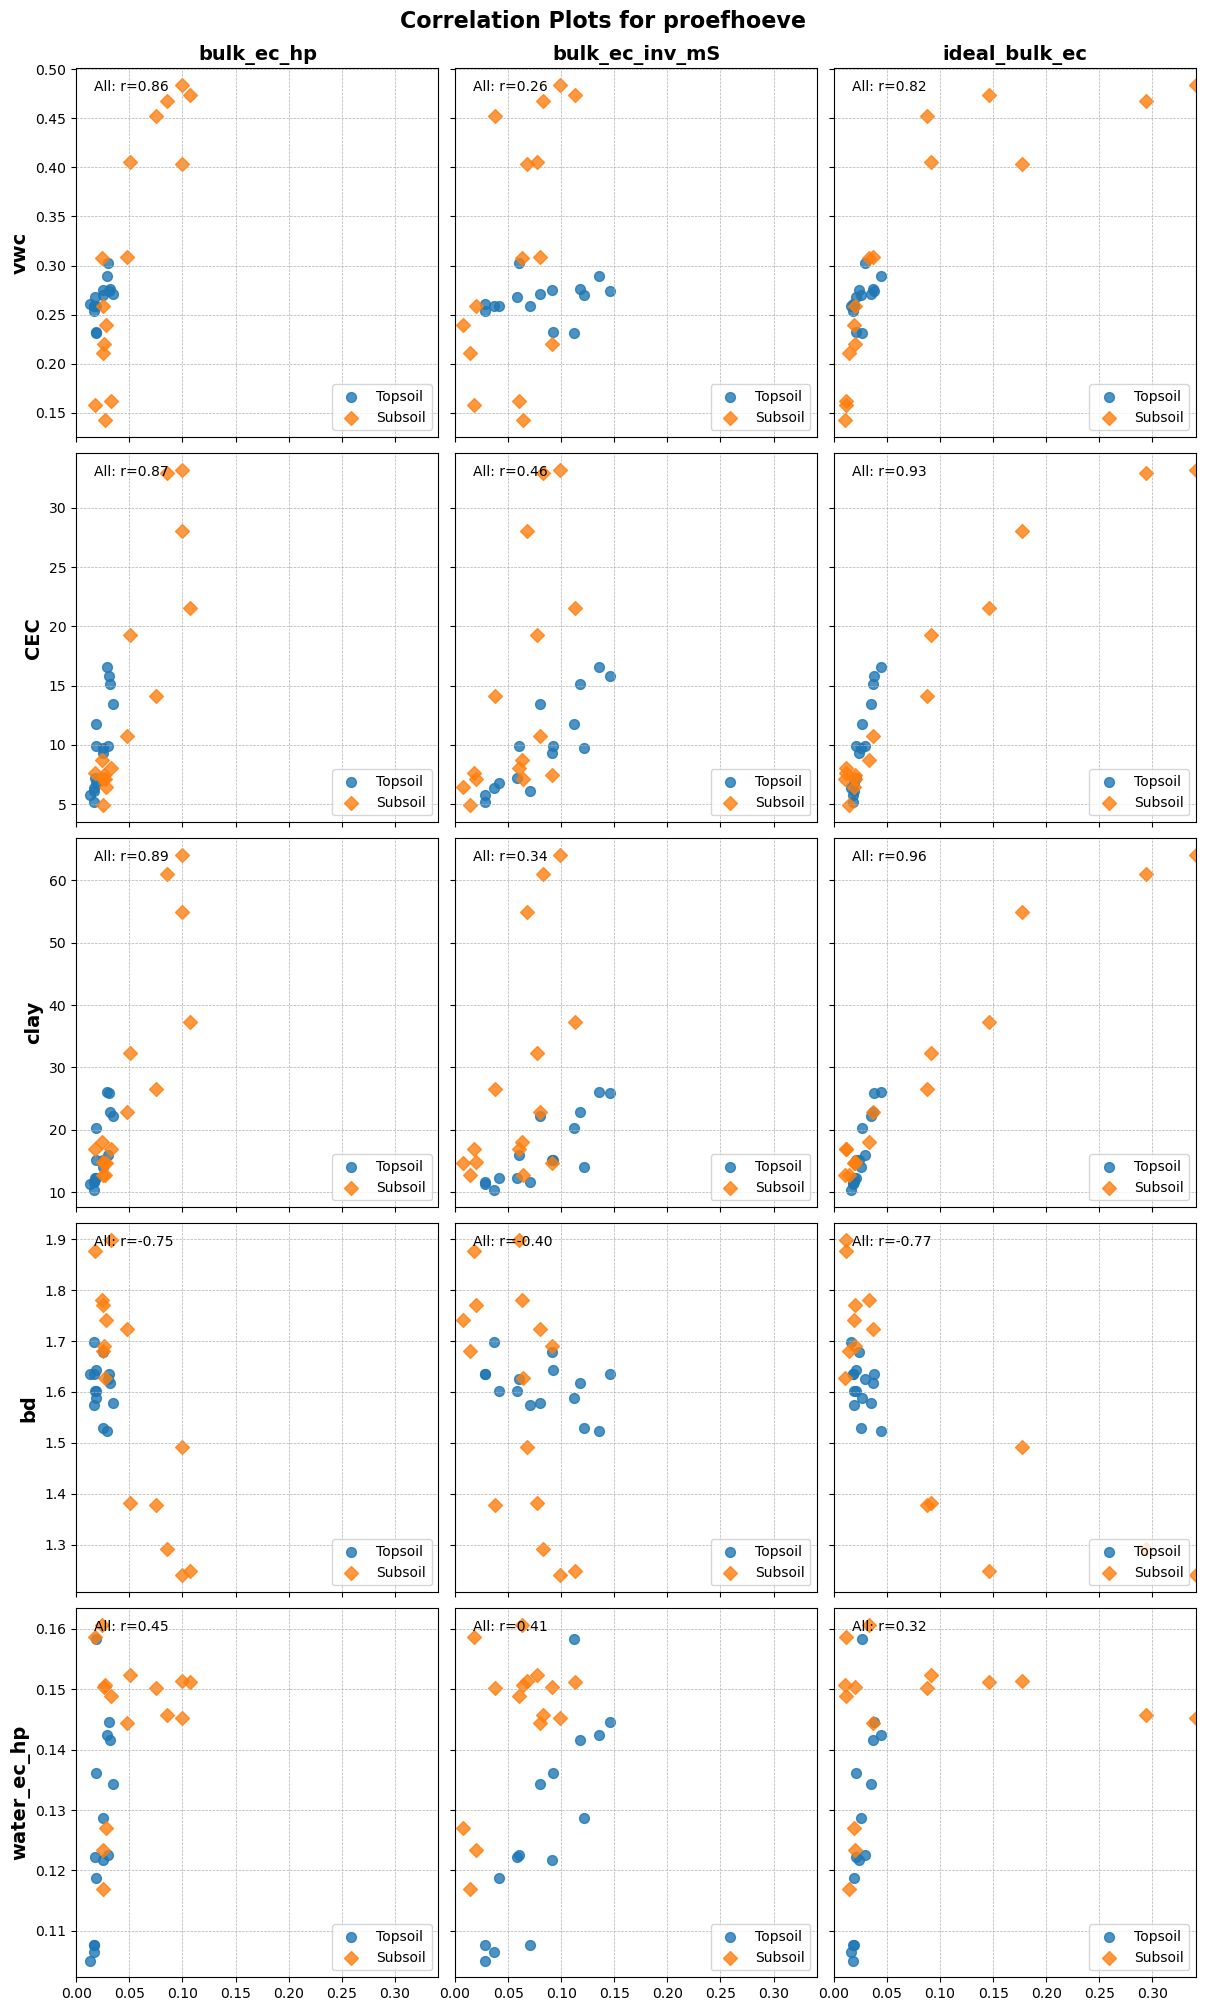

In [ ]:
target_set = [
    'vwc',
    'CEC',
    'clay',
    'bd',
    'water_ec_hp'
]

fig, axes = plt.subplots(5, 3, figsize=(12, 20))
ss = 50  # Reduced size for scatter points

ds['bulk_ec_inv_mS'] = ds.bulk_ec_inv/1000
preds = ['bulk_ec_hp', 'bulk_ec_inv_mS', 'ideal_bulk_ec']

def corr_plot(df, preds, targets):
    global_max_x = float('-inf')

    for target_index, target in enumerate(targets):
        for pred_index, pred in enumerate(preds):
            ax = axes[target_index, pred_index]
            ax.grid(True, which='both', linestyle='--', linewidth=0.5)
            #ax.set_aspect('equal')  # Ensure each subplot is square

            # General correlation coefficient
            general_corr = np.corrcoef(df[pred].dropna(), df[target].dropna())[0, 1]
            ax.text(0.05, 0.95, f'All: r={general_corr:.2f}', transform=ax.transAxes, va="center")

            for layer_cm in [10, 50]:
                x_data = df[df['depth'] == layer_cm][pred]
                y_data = df[df['depth'] == layer_cm][target]
                
                label = 'Topsoil' if layer_cm == 10 else 'Subsoil'
                ax.scatter(x_data, y_data, s=ss, alpha=0.8, marker='o' if layer_cm == 10 else 'D', label=label)

            if target_index == 0:
                ax.set_title(pred, fontweight='bold', fontsize=14)
            if target_index != len(targets) - 1:
                ax.set_xticklabels([])
            if pred_index == 0:
                ax.set_ylabel(target, fontweight='bold', fontsize=14)
            if pred_index != 0:
                ax.set_yticklabels([])

            # Update global max x value
            global_max_x = max(global_max_x, x_data.max())

            ax.legend(loc='lower right')  # Add the legend in the lower right corner

    # Set the same x-axis limits for all subplots
    for ax_row in axes:
        for ax in ax_row:
            ax.set_xlim(0, global_max_x)

corr_plot(ds, preds, target_set)

plt.subplots_adjust(top=0.7)  # You can adjust this value as needed
plt.suptitle(f"Correlation Plots for {profile_prefix}", fontweight='bold', fontsize=16, y=0.999)  # Adjust y as needed
plt.tight_layout(pad=0.5, w_pad=0.4, h_pad=0.8)

folder_path = 'output_images/'
filename = f"Plot_{s_site}.pdf"
plt.savefig(folder_path + filename)
plt.show()

# Deterministic modelling

## Implementation

In [13]:
bulk_ec_inv_50cm = ds.bulk_ec_inv[ds['depth']==50]
bulk_ec_inv_10cm = ds.bulk_ec_inv[ds['depth']==10]

clay_50cm = np.mean(ds.clay[ds['depth']==50])
clay_10cm = np.mean(ds.clay[ds['depth']==10])
bd_50cm = np.mean(ds.bd[ds['depth']==50])
bd_10cm = np.mean(ds.bd[ds['depth']==10])
water_ec_hp_50cm = np.mean(ds.water_ec_hp[ds['depth']==50])
water_ec_hp_10cm = np.mean(ds.water_ec_hp[ds['depth']==10])
water_ec_hp_50cm_t = np.mean(ds.water_ec_hp_t[ds['depth']==50])
water_ec_hp_10cm_t = np.mean(ds.water_ec_hp_t[ds['depth']==10])
clay_mean = np.mean(ds.clay)
bd_mean = np.mean(ds.bd)
water_ec_hp_mean = np.mean(ds.water_ec_hp)
water_ec_hp_mean_t = np.mean(ds.water_ec_hp_t)
temp_50cm = np.mean(ds.temp[ds['depth']==50])
temp_10cm = np.mean(ds.temp[ds['depth']==10])
temp_mean = np.mean(ds.temp)
vwc_50cm = np.mean(ds.vwc[ds['depth']==50])
vwc_10cm = np.mean(ds.vwc[ds['depth']==10])
vwc_mean = np.mean(ds.vwc)
f_ec = 9000
t_conv = 273.15
t_mean_conv = temp_mean+t_conv
t_50cm_conv = temp_50cm+t_conv
t_10cm_conv = temp_10cm+t_conv

In [14]:
if cl == 0.3 and percent == 20 and FM == 'FSeq' and MinM == 'Gauss-Newton' and alpha == 0.07 and remove_coil == False and start_avg == True and constrain == False :
    
  LT0 = predict.Water(
      Soil( 
      bulk_ec = ds.bulk_ec_inv.values/1000,
      frequency_ec = f_ec,
      clay = clay_mean,
      bulk_density = bd_mean,
      water_ec = water_ec_hp_mean_t,
      temperature = t_mean_conv
    ))

  print('LT0', LT0, len(LT0))

  ### Predict using 50 cm layer
  layer_10 = predict.Water(
              Soil( 
              bulk_ec = ds[ds['depth'] == 10].bulk_ec_inv.values/1000,
              frequency_ec=f_ec,
              clay = clay_10cm,
              bulk_density = bd_10cm,
              water_ec = water_ec_hp_10cm_t,
              temperature = t_10cm_conv
                ))

  layer_10_vwc = ds[ds['depth'] == 10].vwc.values/1000

  ### Predict using 50 cm layer
  layer_50 = predict.Water(
              Soil( 
              bulk_ec = ds[ds['depth'] == 50].bulk_ec_inv.values/1000,
              frequency_ec=f_ec,
              clay = clay_50cm,
              bulk_density = bd_50cm,
              water_ec = water_ec_hp_50cm_t,
              temperature = t_50cm_conv
                ))

  layer_50_vwc = ds[ds['depth'] == 50].vwc.values/1000
  LS0 = np.concatenate((layer_10[:9], layer_50, layer_10[9:]))
  print('LS0', LS0, len(LS0))

  ID0 = predict.Water(
        Soil(        
        bulk_ec = ds.bulk_ec_inv.values/1000,
        frequency_ec=f_ec,
        clay = ds.clay.values,
        bulk_density = ds.bd.values,
        water_ec = ds.water_ec_hp_t.values,
        temperature = ds.temp.values+t_conv
        ))

  print('ID0', ID0, len(ID0))

  Y0 = pd.DataFrame({
      'LT0': LT0,
      'LS0': LS0,
      'ID0': ID0
  })

  Y0.to_csv('data/'+s_site+'Y0.csv')

LT0 [0.65  0.289 0.65  0.234 0.65  0.417 0.562 0.318 0.467 0.65  0.452 0.174
 0.644 0.072 0.522 0.293 0.557 0.163 0.433 0.589 0.134 0.415 0.498 0.436
 0.511 0.232 0.405 0.64  0.511 0.557] 30
LS0 [0.65  0.344 0.65  0.282 0.65  0.484 0.639 0.376 0.537 0.389 0.141 0.567
 0.056 0.454 0.245 0.485 0.131 0.371 0.516 0.107 0.355 0.431 0.374 0.443
 0.65  0.281 0.471 0.65  0.585 0.634] 30
ID0 [0.641 0.437 0.65  0.349 0.65  0.494 0.633 0.428 0.619 0.65  0.166 0.249
 0.385 0.111 0.141 0.228 0.611 0.218 0.471 0.149 0.204 0.493 0.353 0.506
 0.522 0.342 0.522 0.627 0.506 0.65 ] 30


In [15]:
def deterministic(feature, target, df, iters=100, round_n=3):
  df.reset_index(drop=True, inplace=True)

  idx_layer_10 = df[df['depth'] == 10].index
  idx_layer_50 = df[df['depth'] == 50].index

  # Select data using boolean masks
  X_layer_10 = df.loc[idx_layer_10, feature].values.reshape(-1, 1)
  Y_layer_10 = df.loc[idx_layer_10, target].values
  X_layer_50 = df.loc[idx_layer_50, feature].values.reshape(-1, 1)
  Y_layer_50 = df.loc[idx_layer_50, target].values

  # Preallocate lists
  DR2_LS, DRMSE_LS = [None] * iters, [None] * iters
  DR2_LT, DRMSE_LT = [None] * iters, [None] * iters
  DR2_10, DRMSE_10 = [None] * iters, [None] * iters
  DR2_50, DRMSE_50 = [None] * iters, [None] * iters
  DR2_ID, DRMSE_ID, ypred_ID_ = [None] * iters, [None] * iters, [None] * iters
  y_ = [None] * iters
  
  for i in range(iters):
    ### Split data of 10cm layer and keep track of test indices
    X_train10, X_test10, y_train10, y_test10, idx_train10, idx_test10 = train_test_split(X_layer_10, Y_layer_10, idx_layer_10, test_size=0.3, random_state=i)
    ### Split data of 50cm layer and keep track of test indices
    X_train50, X_test50, y_train50, y_test50, idx_train50, idx_test50 = train_test_split(X_layer_50, Y_layer_50, idx_layer_50, test_size=0.3, random_state=i)
    ### Combine test indices from both layers
    idx_test = np.concatenate((idx_test10, idx_test50))
    y_test = np.concatenate((y_test10, y_test50)).flatten()
    X_test = (np.concatenate((X_test10, X_test50))/1000).flatten()
    y_[i] = y_test
    
    ### Predict using layer together 
    LT = Soil( 
                bulk_ec = X_test,
                frequency_ec=f_ec,
                clay = clay_mean,
                bulk_density = bd_mean,
                water_ec = water_ec_hp_mean_t,
                temperature = t_mean_conv
                  )
    Dypred_LT = predict.Water(LT)
    DR2_LT[i] = round(r2_score(y_test, Dypred_LT), round_n)
    DRMSE_LT[i] = round(RMSE(y_test, Dypred_LT), round_n)

    ### Predict using 10 cm layer
    layer_10 = Soil( 
                bulk_ec = X_test10.flatten()/1000,
                frequency_ec=f_ec,
                clay = clay_10cm,
                bulk_density = bd_10cm,
                water_ec = water_ec_hp_10cm_t,
                temperature = t_10cm_conv
                  )
    Dypred_10 = predict.Water(layer_10)
    DR2_10[i] = round(r2_score(y_test10, Dypred_10), round_n)
    DRMSE_10[i] = round(RMSE(y_test10, Dypred_10), round_n)

    ### Predict using 50 cm layer
    layer_50 = Soil( 
                bulk_ec = X_test50.flatten()/1000,
                frequency_ec=f_ec,
                clay = clay_50cm,
                bulk_density = bd_50cm,
                water_ec = water_ec_hp_50cm_t,
                temperature = t_50cm_conv
                  )
    Dypred_50 = predict.Water(layer_50)
    DR2_50[i] = round(r2_score(y_test50, Dypred_50), round_n)
    DRMSE_50[i] = round(RMSE(y_test50, Dypred_50), round_n)

    ### Stochastic modelling for layers separate. 
    ### This is a combination of both layer's prediction
    Dypred_LS = np.concatenate((Dypred_10, Dypred_50))

    DR2_LS[i] = round(r2_score(y_test, Dypred_LS), round_n)
    DRMSE_LS[i] = round(RMSE(y_test, Dypred_LS), round_n)

    ### Predict using ideal samples
    filtered_df = df.loc[idx_test]
    ID =  Soil( 
                bulk_ec = X_test,
                frequency_ec=f_ec,
                clay = filtered_df['clay'].values,
                bulk_density = filtered_df['bd'].values,
                water_ec = filtered_df['water_ec_hp_t'].values,
                temperature = filtered_df['temp'].values+t_conv
                  )
    Dypred_ID = predict.Water(ID)
    ypred_ID_[i] = Dypred_ID
    DR2_ID[i] = round(r2_score(y_test, Dypred_ID), round_n)
    DRMSE_ID[i] = round(RMSE(y_test, Dypred_ID), round_n)

  return DR2_LT, DRMSE_LT, DR2_ID, DRMSE_ID, DR2_LS, DRMSE_LS, DR2_10, DRMSE_10, DR2_50, DRMSE_50

Dresults = {}
%timeit
target = 'bulk_ec_inv'
DR2_LT, DRMSE_LT, DR2_ID, DRMSE_ID, DR2_LS, DRMSE_LS, DR2_10, DRMSE_10, DR2_50, DRMSE_50 = deterministic('bulk_ec_inv', 'vwc', ds)
print(DR2_LT, DRMSE_LT, DR2_ID, DRMSE_ID, DR2_LS, DRMSE_LS, DR2_10, DRMSE_10, DR2_50, DRMSE_50)
Dresults['bulk_ec_inv'] = {
      'LT': {'R2': DR2_LT, 'RMSE': DRMSE_LT},
      'LS': {'R2': DR2_LS, 'RMSE': DRMSE_LS},
      'ID': {'R2': DR2_ID, 'RMSE': DRMSE_ID},
'layer 10': {'R2': DR2_10, 'RMSE': DRMSE_10},
'layer 50': {'R2': DR2_50, 'RMSE': DRMSE_50}
}
%timeit

[-10.252, -6.069, -4.32, -7.043, -8.808, -1.589, -6.807, -4.715, -7.557, -4.084, -12.104, -11.522, -3.029, -3.151, -4.396, -5.893, -5.692, -4.246, -8.653, -3.53, -5.582, -5.967, -5.517, -3.354, -10.768, -7.604, -3.04, -7.054, -7.82, -5.532, -5.078, -5.257, -6.096, -9.597, -10.94, -4.811, -7.604, -2.62, -7.523, -3.201, -10.05, -5.902, -3.874, -3.929, -6.068, -5.924, -9.095, -3.585, -3.237, -5.959, -5.425, -3.805, -3.598, -7.295, -5.936, -5.199, -12.134, -5.87, -21.114, -7.054, -5.21, -7.733, -7.276, -5.486, -5.257, -3.519, -25.653, -8.294, -4.809, -5.658, -4.48, -4.912, -5.695, -2.231, -8.36, -2.586, -8.448, -7.467, -6.979, -5.211, -4.61, -5.539, -3.586, -4.507, -16.003, -9.165, -19.579, -2.996, -8.039, -7.118, -10.252, -10.903, -3.965, -7.841, -2.658, -7.595, -4.027, -9.238, -5.658, -13.979] [0.237, 0.208, 0.234, 0.267, 0.265, 0.152, 0.25, 0.213, 0.283, 0.217, 0.221, 0.237, 0.168, 0.181, 0.19, 0.242, 0.246, 0.192, 0.265, 0.17, 0.176, 0.198, 0.191, 0.201, 0.248, 0.239, 0.174, 0.256, 0.2

## Process results

In [16]:
# Convert results to DataFrame for easier processing
Dresults_df = pd.DataFrame(Dresults).T.stack().reset_index()
Dresults_df.columns = ['Feature', 'Model', 'Scores']
Dresults_df = Dresults_df.join(pd.DataFrame(Dresults_df.pop('Scores').values.tolist()))

# Calculate median of each list in RMSE and R2 columns
Dresults_df['Median RMSE'] = Dresults_df['RMSE'].apply(lambda x: np.median(x))
Dresults_df['Median R2'] = Dresults_df['R2'].apply(lambda x: np.median(x))

# Create a DataFrame for median scores
median_scores = Dresults_df[['Feature', 'Model', 'Median RMSE', 'Median R2']]
print('median_scores', median_scores)

# Find best features based on criteria
error_criteria = 'R2'  # Change to 'R2' to select based on R2
if error_criteria == 'RMSE':
    best_features = median_scores.loc[median_scores.groupby('Model')['Median RMSE'].idxmin()]
else:
    best_features = median_scores.loc[median_scores.groupby('Model')['Median R2'].idxmax()]

# Prepare final DataFrame
DR2_results = pd.DataFrame({
    'Target': target,
    'Best Feature LT': best_features.loc[best_features['Model'] == 'LT', 'Feature'].values[0],
    'R2 LT':           best_features.loc[best_features['Model'] == 'LT', 'Median R2'].values[0],
    'Best Feature ID': best_features.loc[best_features['Model'] == 'ID', 'Feature'].values[0],
    'R2 ID':           best_features.loc[best_features['Model'] == 'ID', 'Median R2'].values[0],
    'Best Feature LS': best_features.loc[best_features['Model'] == 'LS', 'Feature'].values[0],
    'R2 LS':           best_features.loc[best_features['Model'] == 'LS', 'Median R2'].values[0],
    'Best Feature 10': best_features.loc[best_features['Model'] == 'layer 10', 'Feature'].values[0],
    'R2 10':           best_features.loc[best_features['Model'] == 'layer 10', 'Median R2'].values[0],
    'Best Feature 50': best_features.loc[best_features['Model'] == 'layer 50', 'Feature'].values[0],
    'R2 50':           best_features.loc[best_features['Model'] == 'layer 50', 'Median R2'].values[0]
}, index=[0])

folder_path = 'output_tables/'
file_name = 'DR2_results' + '_' + s_site + '_' + em_intype + '_' + cal + '_' + instrument_code + '.xlsx'
DR2_results.to_excel(folder_path + file_name, index=False)
DR2_results

bulk_ec_inv_data = median_scores[median_scores['Feature'] == 'bulk_ec_inv']

DR2_results_inv = pd.DataFrame({
    'Target': target,
    'Inverted EC LT R2': bulk_ec_inv_data.loc[bulk_ec_inv_data['Model'] == 'LT', 'Median R2'].values[0],
    'Inverted EC ID R2': bulk_ec_inv_data.loc[bulk_ec_inv_data['Model'] == 'ID', 'Median R2'].values[0],
    'Inverted EC LS R2': bulk_ec_inv_data.loc[bulk_ec_inv_data['Model'] == 'LS', 'Median R2'].values[0],
    'Inverted EC 10 R2': bulk_ec_inv_data.loc[bulk_ec_inv_data['Model'] == 'layer 10', 'Median R2'].values[0],
    'Inverted EC 50 R2': bulk_ec_inv_data.loc[bulk_ec_inv_data['Model'] == 'layer 50', 'Median R2'].values[0],
    }, index=[0])

folder_path = 'output_tables/'
file_name = 'DR2_results_inv_' + '_' + s_site + '_' + em_intype + '_' + cal + '_' + instrument_code + '.xlsx'
DR2_results_inv.to_excel(folder_path + file_name, index=False)
DR2_results_inv


median_scores        Feature     Model  Median RMSE  Median R2
0  bulk_ec_inv        ID       0.2705    -9.0795
1  bulk_ec_inv        LS       0.2320    -6.3690
2  bulk_ec_inv        LT       0.2260    -5.8815
3  bulk_ec_inv  layer 10       0.2995  -343.9875
4  bulk_ec_inv  layer 50       0.1405    -0.5900


,Target,Inverted EC LT R2,Inverted EC ID R2,Inverted EC LS R2,Inverted EC 10 R2,Inverted EC 50 R2
0,bulk_ec_inv,-5.8815,-9.0795,-6.369,-343.9875,-0.59


## Plot results

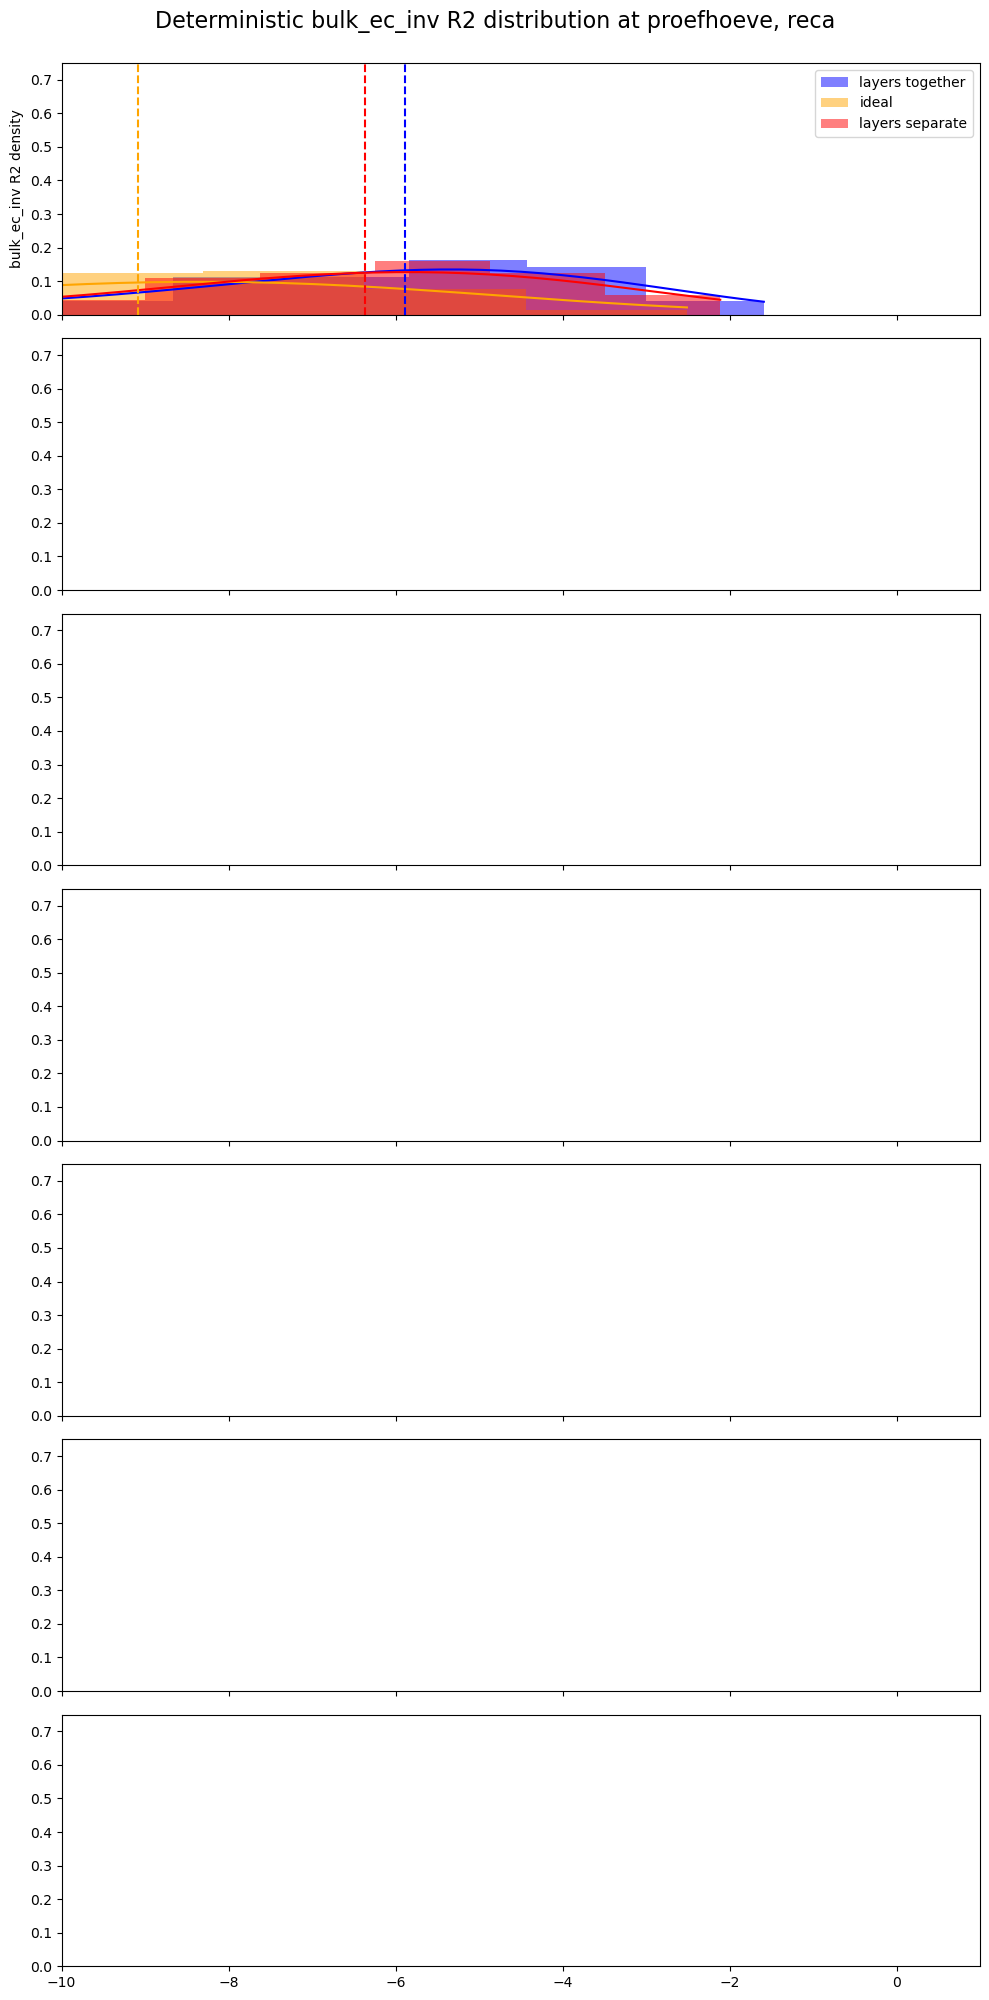

In [17]:
plot_det(Dresults, feature_set, target, profile_prefix, em_intype, cal, s_site, 'R2', 'blue', 'red', 'orange')

# Stochastic modelling

## Implementation

In [18]:
def stochastic(features, target, df, criteria='R2', n=4, iters=100, round_n=3):
    ### Defining lists to store results and error indicators
    SR2_train_10_, SR2_test_10_, Sypred_test_10_ = [], [], []
    SR2_train_50_, SR2_test_50_, Sypred_test_50_ = [], [], []
    SR2_train_LT_, SR2_test_LT_ = [], []
    SR2_train_LS_, SR2_test_LS_ = [], []
    y_test_ = []

    ### Extract indices for 10 cm and 50 cm layers
    idx_layer_10 = df[df['depth'] == 10].index
    idx_layer_50 = df[df['depth'] == 50].index
    ### Select data at 10 cm depth
    X_layer_10 = df.loc[idx_layer_10, features].values.reshape(-1, 1)
    Y_layer_10 = df.loc[idx_layer_10, target].values
    ### Select data at 50 cm depth
    X_layer_50 = df.loc[idx_layer_50, features].values.reshape(-1, 1)
    Y_layer_50 = df.loc[idx_layer_50, target].values

    for i in range(iters):
        ### Split data of 10cm layer and keep track of test indices
        X_train10, X_test10, y_train10, y_test10 = train_test_split(X_layer_10, Y_layer_10, test_size=0.3, random_state=i)
        SR2_train_10, SR2_test_10, Sypred_test_10 = [], [], []
        ### Split data of 50cm layer and keep track of test indices
        X_train50, X_test50, y_train50, y_test50 = train_test_split(X_layer_50, Y_layer_50, test_size=0.3, random_state=i)
        SR2_train_50, SR2_test_50, Sypred_test_50 = [], [], []
        ### Combine test indices from both layers
        y_train = np.concatenate((y_train10, y_train50))
        y_test = np.concatenate((y_test10, y_test50)).flatten()
        X_train = np.concatenate((X_train10, X_train50))
        X_test = (np.concatenate((X_test10, X_test50))/1000).flatten()
        y_test_.append(y_test)

        SR2_train_LS, SR2_test_LS = [], []
        SR2_train_LT, SR2_test_LT = [], []

        for k in range(n):

            #### Stochastic modelling for layers together
            polyLT = PolynomialFeatures(degree=k)
            polyLT.fit(X_train)
            Xt_trainLT = polyLT.transform(X_train)
            Xt_testLT = polyLT.transform(X_test.reshape(-1, 1))
            LinRegLT = LinearRegression()
            LinRegLT.fit(Xt_trainLT, y_train)
            Sypred_trainLT = LinRegLT.predict(Xt_trainLT)
            Sypred_testLT = LinRegLT.predict(Xt_testLT)
                # Save results and error indicators over polinomial degrees
            SR2_train_LT.append(round(r2_score(y_train, Sypred_trainLT), round_n))
            SR2_test_LT.append(round(r2_score(y_test, Sypred_testLT), round_n))

            #### Stochastic modelling 10 cm layer
            LinReg10 = LinearRegression()
            poly10 = PolynomialFeatures(degree=k)
            poly10.fit(X_train10)
            Xt_train10 = poly10.transform(X_train10)
            Xt_test10 = poly10.transform(X_test10)
            LinReg10.fit(Xt_train10, y_train10)
            Sypred_train10 = LinReg10.predict(Xt_train10)
            Sypred_test10 = LinReg10.predict(Xt_test10)
                # Save results and error indicators over polinomial degrees
            Sypred_test_10.append(Sypred_test10)
            SR2_train_10.append(round(r2_score(y_train10, Sypred_train10), round_n))
            SR2_test_10.append(round(r2_score(y_test10, Sypred_test10), round_n))

            #### Stochastic modelling 50 cm layer
            LinReg50 = LinearRegression()
            poly50 = PolynomialFeatures(degree=k)
            poly50.fit(X_train50)
            Xt_train50 = poly50.transform(X_train50)
            Xt_test50 = poly50.transform(X_test50)
            LinReg50.fit(Xt_train50, y_train50)
            Sypred_train50 = LinReg50.predict(Xt_train50)
            Sypred_test50 = LinReg50.predict(Xt_test50)
                # Save results and error indicators over polinomial degrees
            Sypred_test_50.append(Sypred_test50)
            SR2_train_50.append(round(r2_score(y_train50, Sypred_train50), round_n))
            SR2_test_50.append(round(r2_score(y_test50, Sypred_test50), round_n))

            ### Stochastic modelling for layers separate. 
            ### This is a combination of both layer's prediction
            Sypred_train_LS = np.concatenate((Sypred_train10, Sypred_train50))
            Sypred_test_LS = np.concatenate((Sypred_test10, Sypred_test50))

            SR2_train_LS.append(round(r2_score(y_train, Sypred_train_LS), round_n))
            SR2_test_LS.append(round(r2_score(y_test, Sypred_test_LS), round_n))

        # Save results over all splits
        SR2_train_10_.append(SR2_train_10)
        SR2_test_10_.append(SR2_test_10)
        Sypred_test_10_.append(Sypred_test_10)

        SR2_train_50_.append(SR2_train_50)
        SR2_test_50_.append(SR2_test_50)
        Sypred_test_50_.append(Sypred_test_50)

        SR2_train_LS_.append(SR2_train_LS)
        SR2_test_LS_.append(SR2_test_LS)

        SR2_train_LT_.append(SR2_train_LT)
        SR2_test_LT_.append(SR2_test_LT)

        SR2_test_LS0 = [inner_list[0] for inner_list in SR2_test_LS_]
        SR2_test_LS1 = [inner_list[1] for inner_list in SR2_test_LS_]
        SR2_test_LS2 = [inner_list[2] for inner_list in SR2_test_LS_]
        SR2_test_LS3 = [inner_list[3] for inner_list in SR2_test_LS_]

        SR2_test_LT0 = [inner_list[0] for inner_list in SR2_test_LT_]
        SR2_test_LT1 = [inner_list[1] for inner_list in SR2_test_LT_]
        SR2_test_LT2 = [inner_list[2] for inner_list in SR2_test_LT_]
        SR2_test_LT3 = [inner_list[3] for inner_list in SR2_test_LT_]
        #####

        SR2_test_10_0 = [inner_list[0] for inner_list in SR2_test_10_]
        SR2_test_10_1 = [inner_list[1] for inner_list in SR2_test_10_]
        SR2_test_10_2 = [inner_list[2] for inner_list in SR2_test_10_]
        SR2_test_10_3 = [inner_list[3] for inner_list in SR2_test_10_]

        SR2_test_50_0 = [inner_list[0] for inner_list in SR2_test_50_]
        SR2_test_50_1 = [inner_list[1] for inner_list in SR2_test_50_]
        SR2_test_50_2 = [inner_list[2] for inner_list in SR2_test_50_]
        SR2_test_50_3 = [inner_list[3] for inner_list in SR2_test_50_]

    #########################
    if criteria == 'R2':

        SR2_10 = [SR2_test_10_0, SR2_test_10_1, SR2_test_10_2, SR2_test_10_3]
        SR2_meadian_10 = [np.median(sublist) for sublist in SR2_10]
        best_n_10 = SR2_meadian_10.index(np.max(SR2_meadian_10))
        SR2_test_10b = SR2_10[best_n_10]

        SR2_50 = [SR2_test_50_0, SR2_test_50_1, SR2_test_50_2, SR2_test_50_3]
        SR2_meadian_50 = [np.median(sublist) for sublist in SR2_50]
        best_n_50 = SR2_meadian_50.index(np.max(SR2_meadian_50))
        SR2_test_50b = SR2_50[best_n_50]

        SR2_LT = [SR2_test_LT0, SR2_test_LT1, SR2_test_LT2, SR2_test_LT3]
        SR2_meadian_LT = [np.median(sublist) for sublist in SR2_LT]
        best_n_LT = SR2_meadian_LT.index(np.max(SR2_meadian_LT))
        SR2_test_LTb = SR2_LT[best_n_LT]

        SR2_LS = [SR2_test_LS0, SR2_test_LS1, SR2_test_LS2, SR2_test_LS3]
        SR2_meadian_LS = [np.median(sublist) for sublist in SR2_LS]
        best_n_LS = SR2_meadian_LS.index(np.max(SR2_meadian_LS))
        SR2_test_LSb = SR2_LS[best_n_LS]

        ### Based on the best dgrees per layer, make up the LS2 model, the one that uses models for layer which are not necesarely equal. 
        SR2_test_LS2b = []
        for j in range(iters):
            Sypred_test_10b = [inner_list[best_n_10] for inner_list in Sypred_test_10_][j]
            Sypred_test_50b = [inner_list[best_n_50] for inner_list in Sypred_test_50_][j]

            Sypred_LS2b = np.concatenate((Sypred_test_10b, Sypred_test_50b))
            SR2_test_LS2b.append(round(r2_score(y_test_[j], Sypred_LS2b), round_n))

        best_n_LS2 = [best_n_10, best_n_50]
    best_ns = [best_n_LT, best_n_LS, best_n_LS2]
    return SR2_test_LTb, SR2_test_LSb, SR2_test_LS2b, SR2_test_10b, SR2_test_50b, best_ns

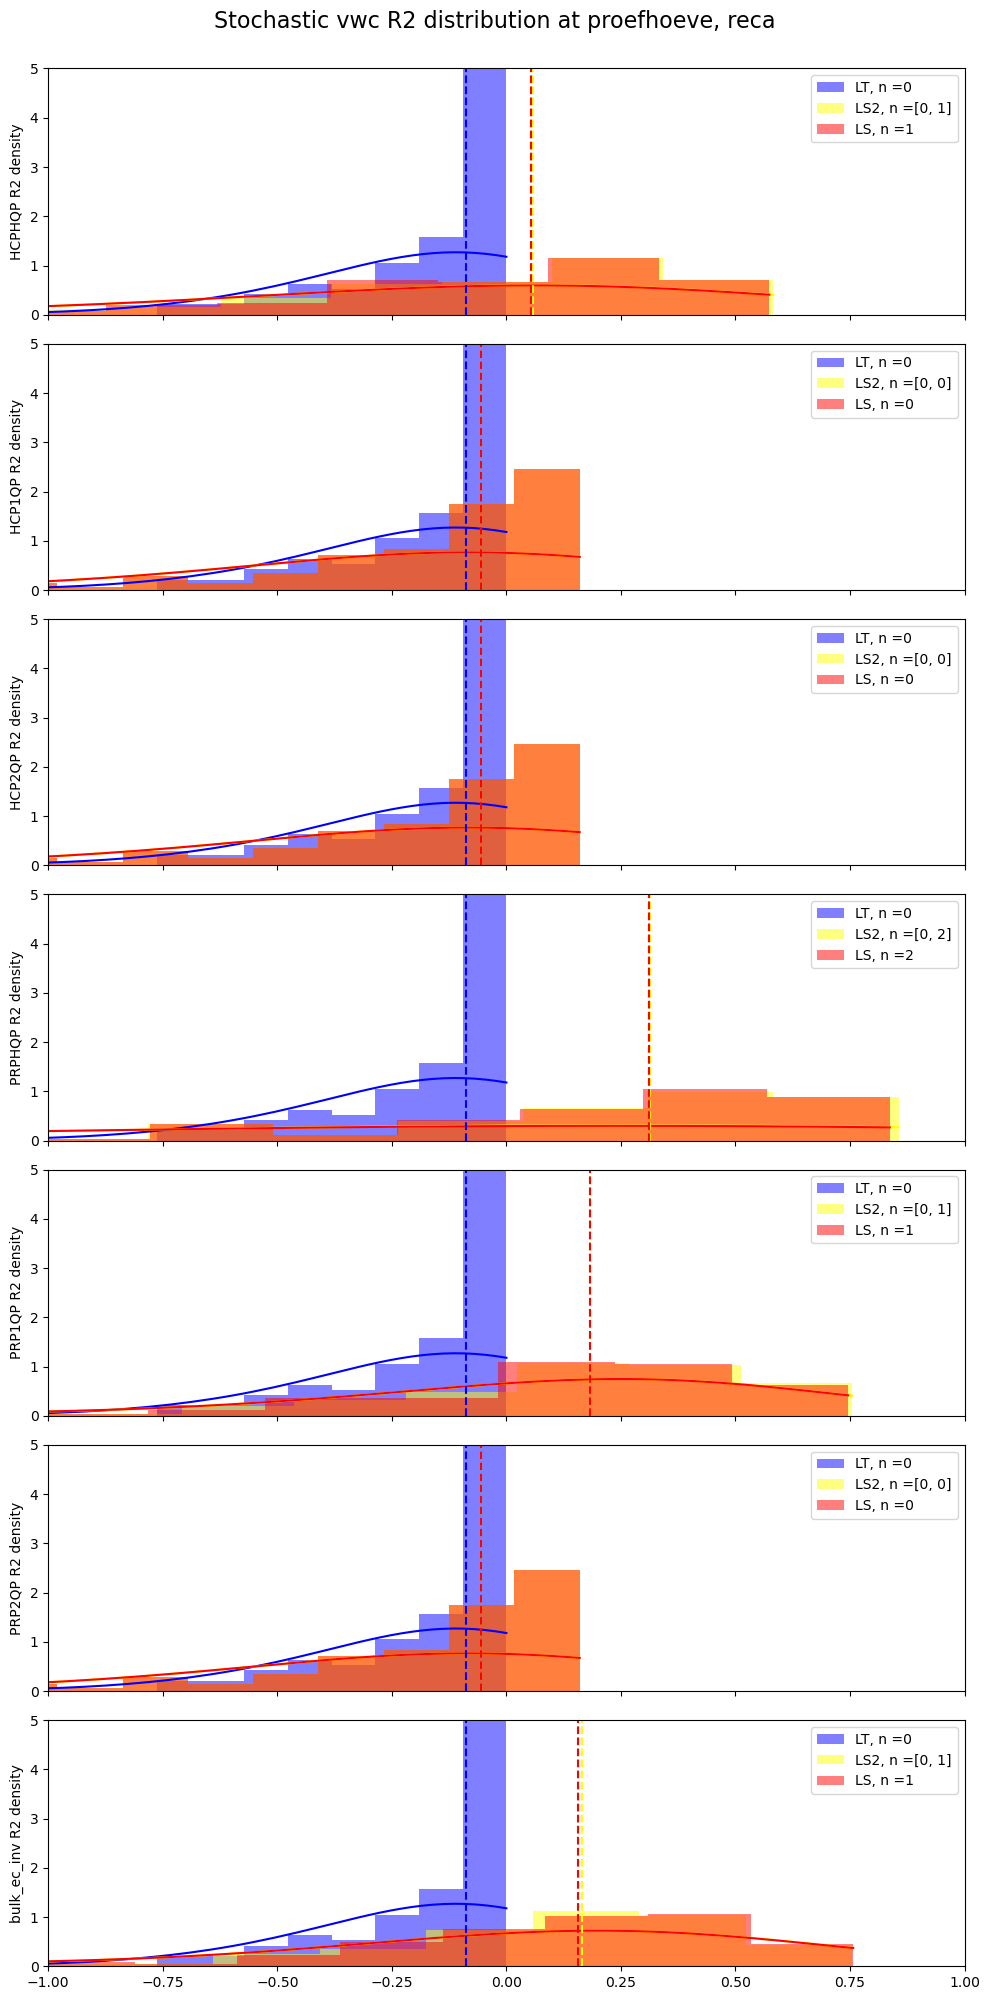

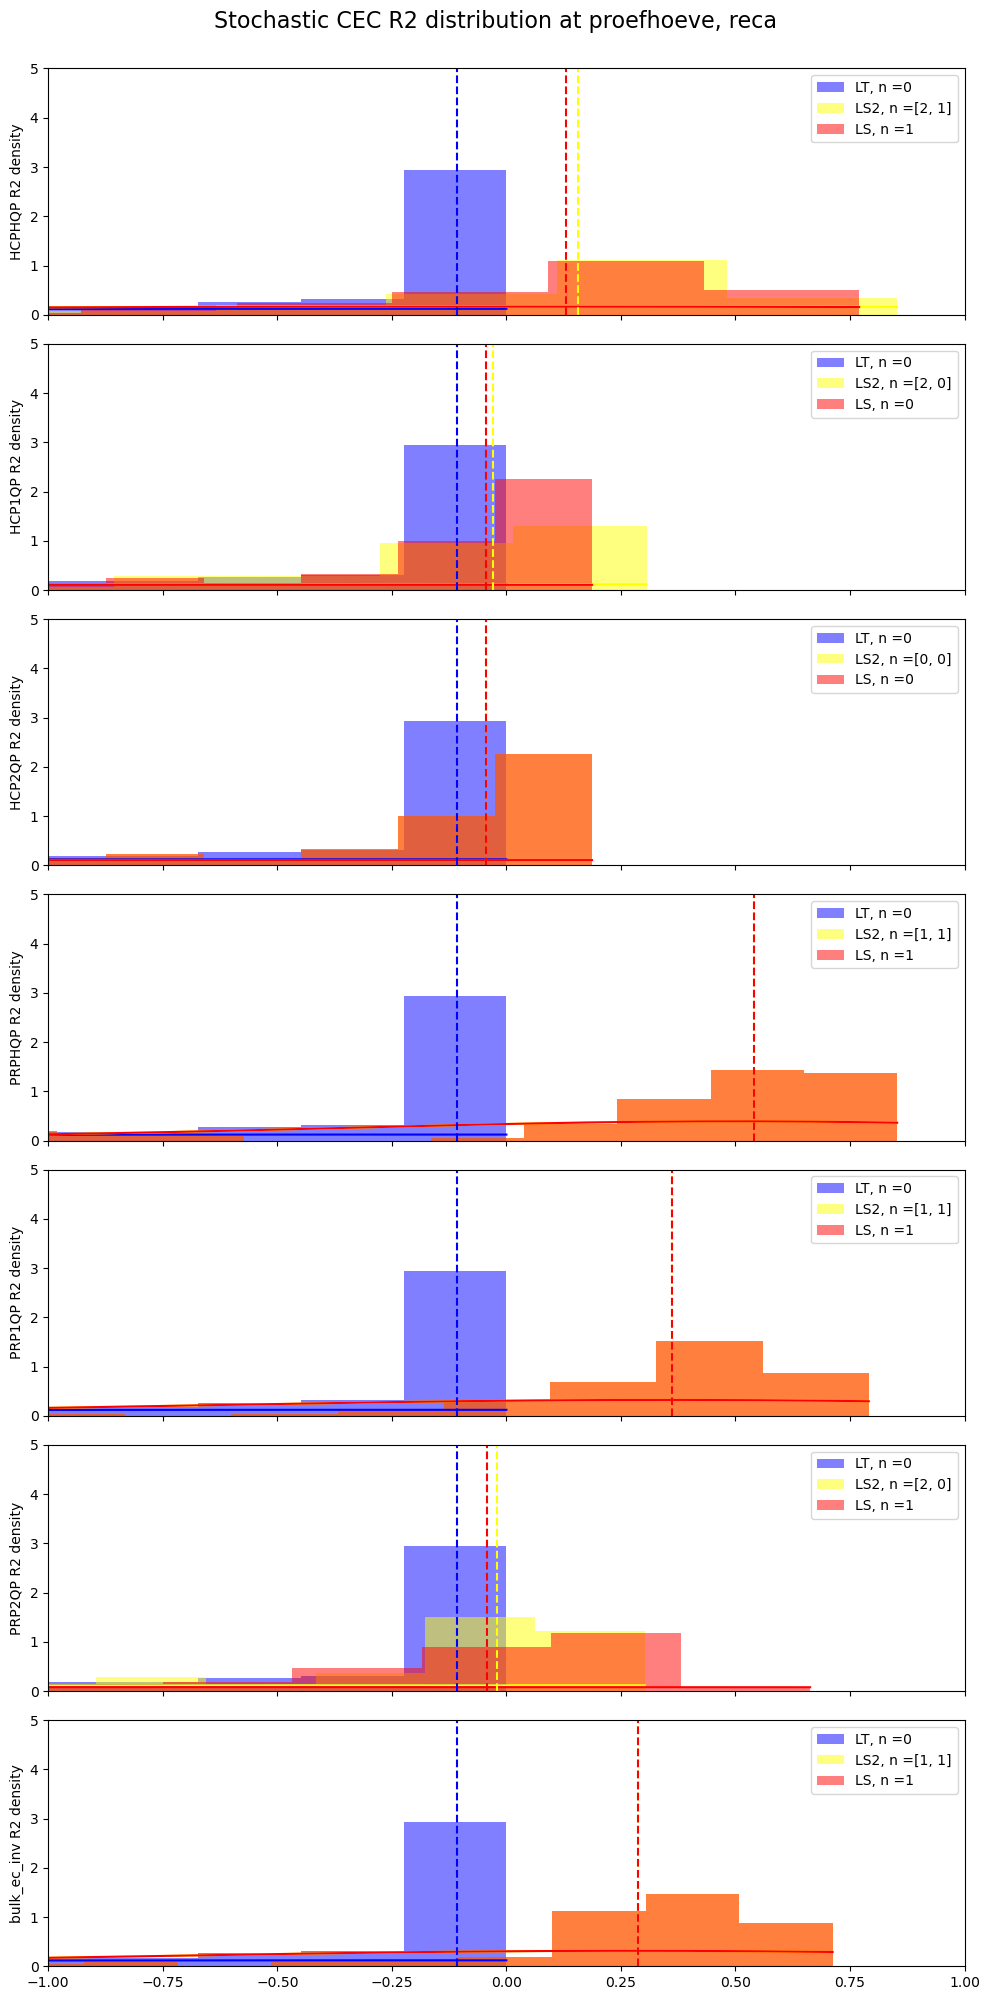

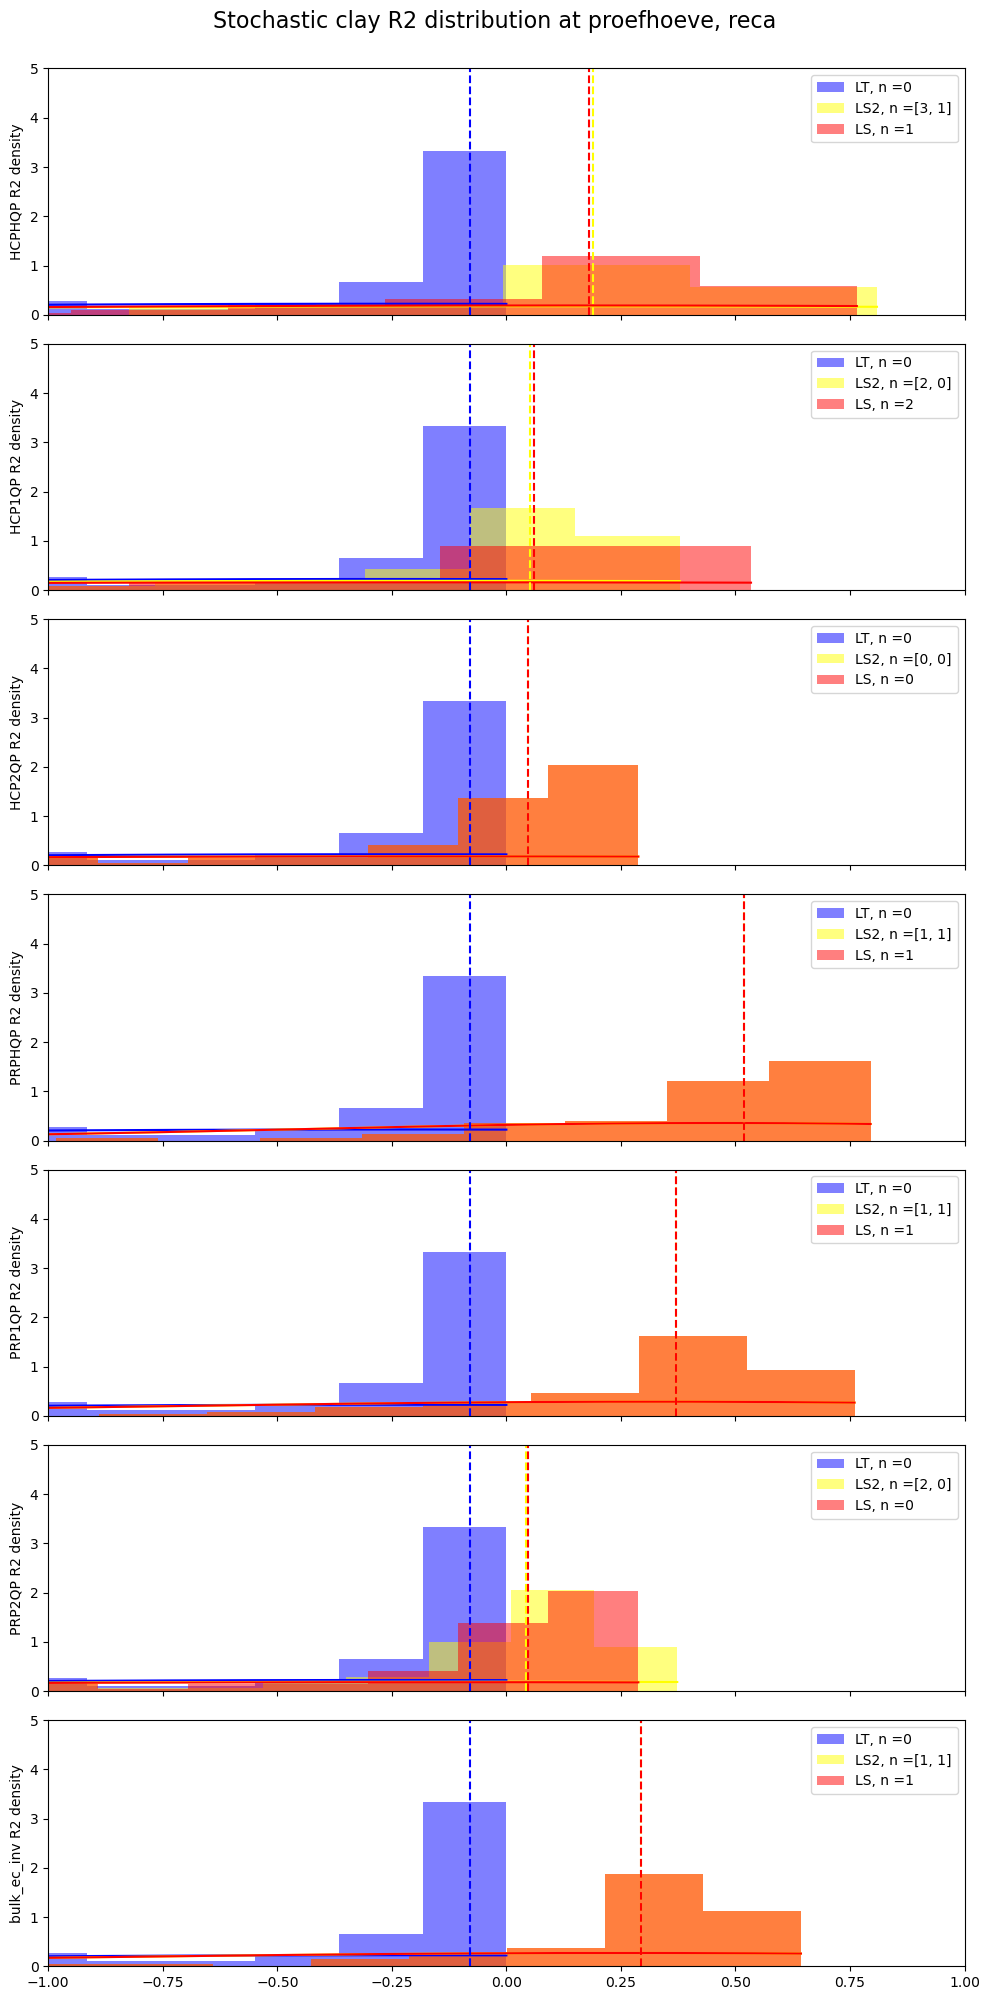

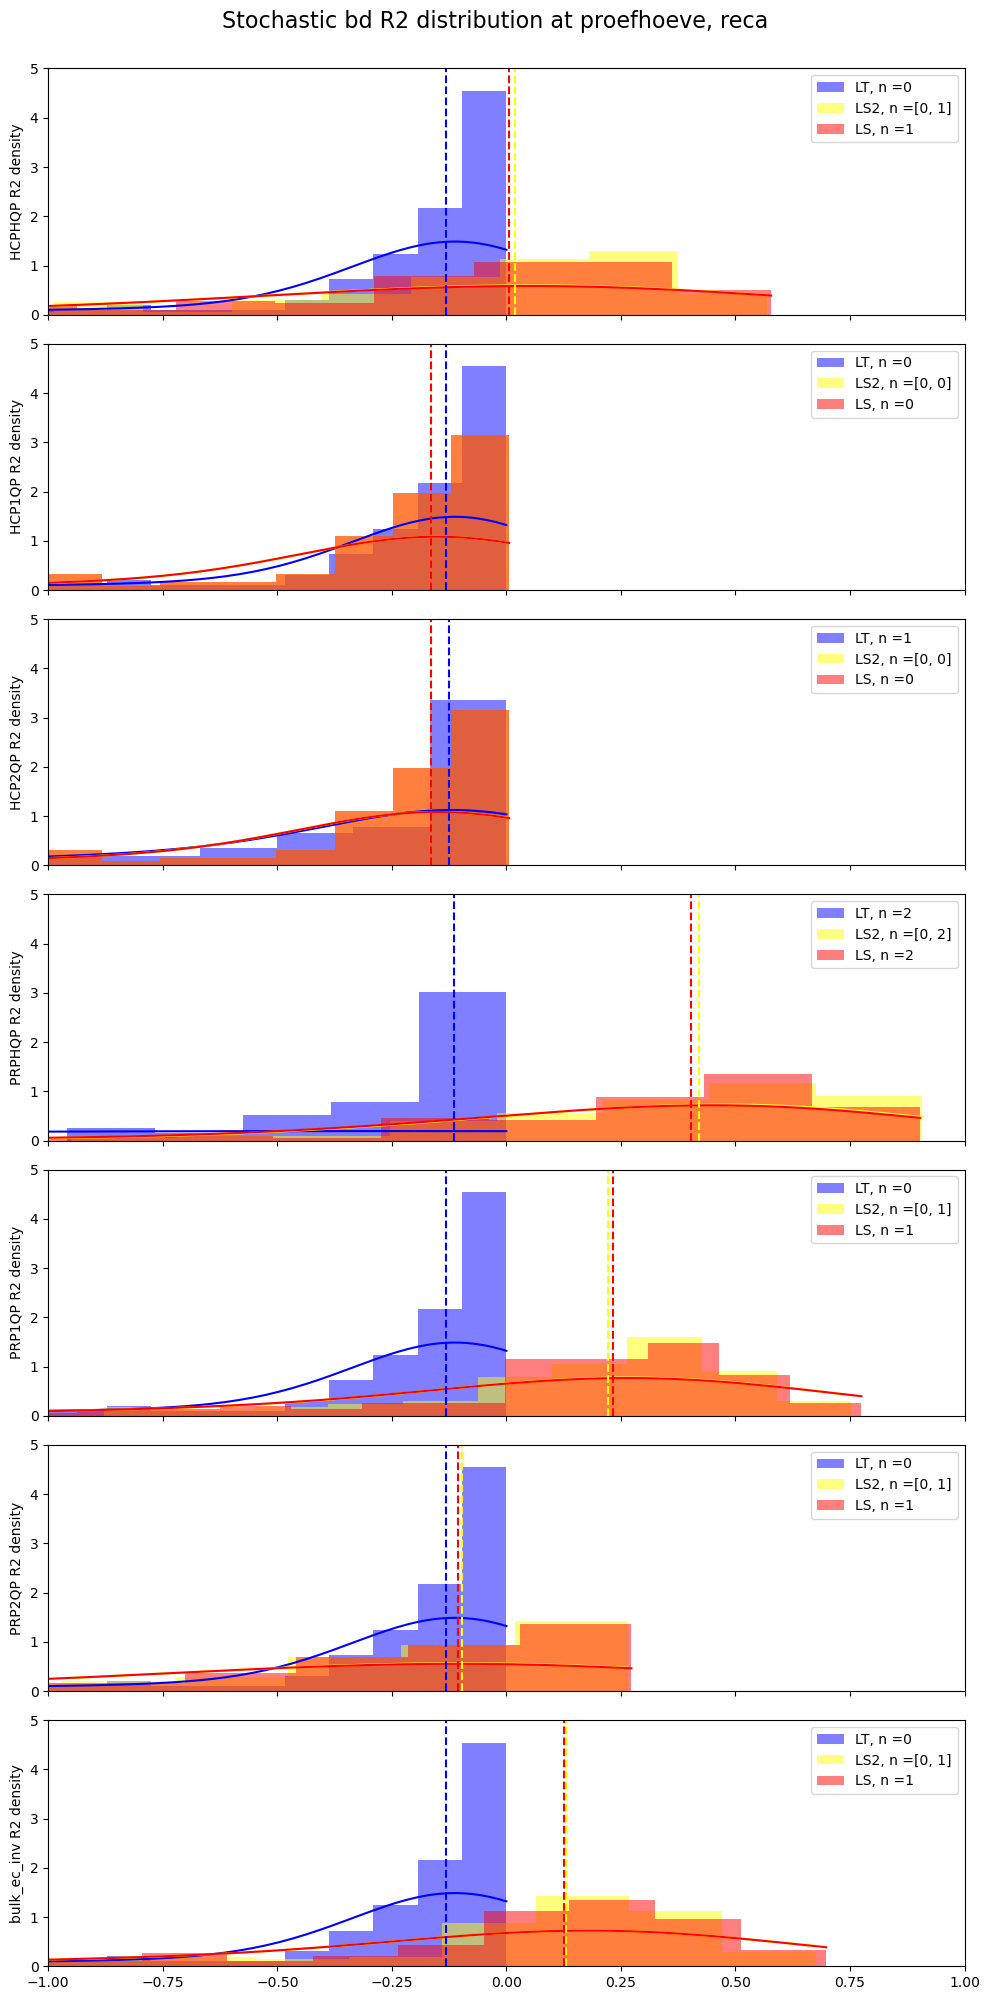

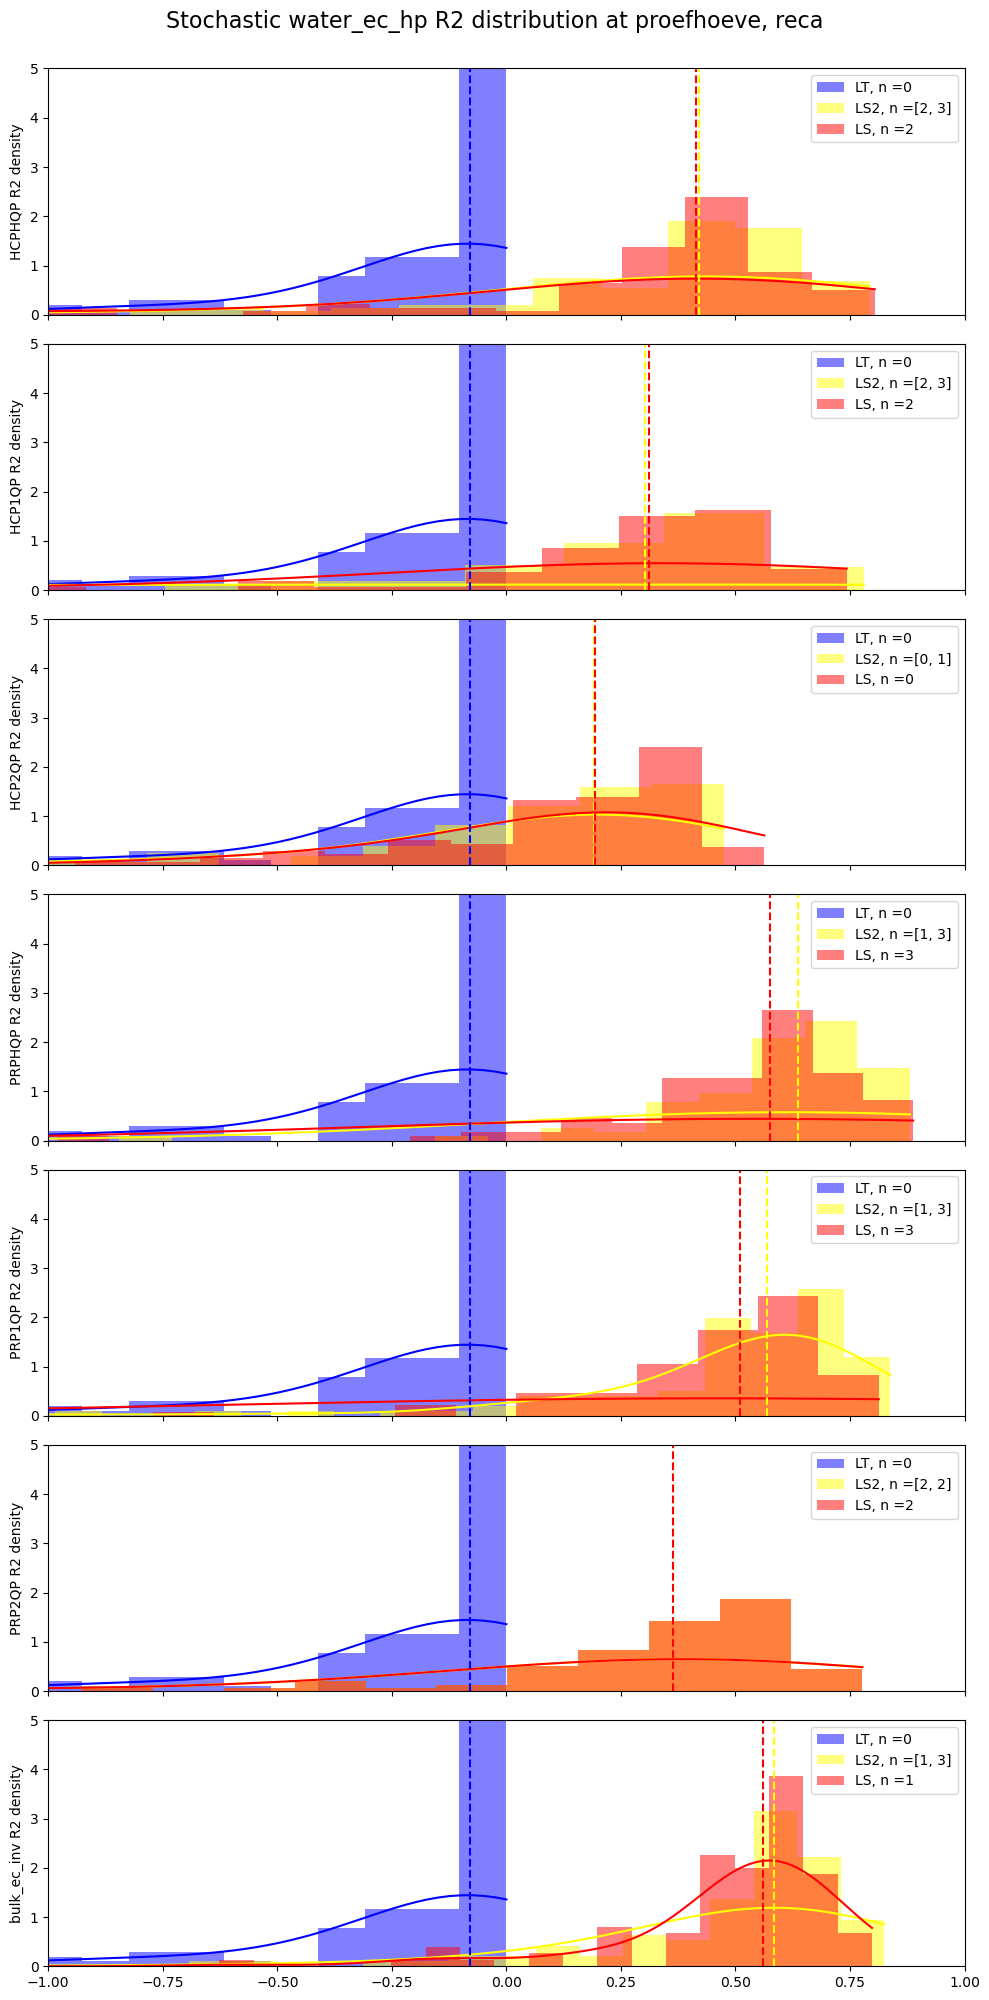

In [19]:
###########################
#### Store results ########

pdfs = []
Sresults = {}
SR2_results = pd.DataFrame(columns=['Target', 'BestFeatureLT', 'LT', 'BestFeatureLS', 'LS', 'BestFeatureLS2', 'LS2'
                               , 'BestFeature10', 'Top_layer', 'BestFeature50', 'Bottom_layer'])

for i, target in enumerate(target_set):
    max_r2_lt = -float('inf')
    max_r2_ls = -float('inf')
    max_r2_ls2 = -float('inf')
    max_r2_10 = -float('inf')
    max_r2_50 = -float('inf')
    best_feature_lt = None
    best_feature_ls = None
    best_feature_ls2 = None

    for feature in feature_set:
        SR2_test_LT, SR2_test_LS, SR2_test_LS2, SR2_test_10, SR2_test_50, best_ns = stochastic(feature, target, ds)

        Sresults[feature] = {
            'LT': {'R2': SR2_test_LT, 'n': best_ns[0]},
            'LS': {'R2': SR2_test_LS, 'n': best_ns[1]},
            'LS2': {'R2': SR2_test_LS2, 'n': best_ns[2]},
            '10': {'R2': SR2_test_10, 'n': best_ns[2]},
            '50': {'R2': SR2_test_50, 'n': best_ns[2]}
        }

    for feature, result in Sresults.items():
        if np.median(result['LT']['R2']) > max_r2_lt:
            max_r2_lt = np.median(result['LT']['R2'])
            best_feature_lt = feature

        if np.median(result['LS']['R2']) > max_r2_ls:
            max_r2_ls = np.median(result['LS']['R2'])
            best_feature_ls = feature

        if np.median(result['LS2']['R2']) > max_r2_ls2:
            max_r2_ls2 = np.median(result['LS2']['R2'])
            best_feature_ls2 = feature

        if np.median(result['10']['R2']) > max_r2_10:
            max_r2_10 = np.median(result['10']['R2'])
            best_feature_10 = feature

        if np.median(result['50']['R2']) > max_r2_50:
            max_r2_50 = np.median(result['50']['R2'])
            best_feature_50 = feature

    SR2_results.loc[i, 'Target'] = target
    SR2_results.loc[i, 'BestFeatureLT'] = best_feature_lt
    SR2_results.loc[i, 'LT'] = max_r2_lt
    SR2_results.loc[i, 'BestFeatureLS'] = best_feature_ls
    SR2_results.loc[i, 'LS'] = max_r2_ls
    SR2_results.loc[i, 'BestFeatureLS2'] = best_feature_ls2
    SR2_results.loc[i, 'LS2'] = max_r2_ls2
    SR2_results.loc[i, 'BestFeature10'] = best_feature_10
    SR2_results.loc[i, 'Top_layer'] = max_r2_10
    SR2_results.loc[i, 'BestFeature50'] = best_feature_50
    SR2_results.loc[i, 'Bottom_layer'] = max_r2_50

    file_name = plot_stoch(Sresults, feature_set, target, profile_prefix, em_intype, cal, s_site, 'R2', 'blue', 'red', 'yellow')
    pdfs.append(file_name)

In [20]:
folder_path = 'output_images/'

# Merge and save PDFs
merger = PdfMerger()
for pdf in pdfs:
    merger.append(folder_path + pdf)
merged_pdf_filename = f"R2_stoch_{s_site}_{cal}_{em_intype}.pdf"
outfile_transect_pdf = os.path.join(folder_path, merged_pdf_filename)
merger.write(outfile_transect_pdf)
merger.close()
for pdf in pdfs:
    os.remove(folder_path + pdf)
clear_output(wait=False)

In [21]:
folder_path = 'output_tables/'
file_name = f'{emfile_prefix}_SR2_results_{cl}_{percent}_{FM}_{MinM}_{alpha}_{remove_coil}_{start_avg}_{constrain}.csv'
SR2_results.to_csv(folder_path + file_name, index=False)

SR2_results

,Target,BestFeatureLT,LT,BestFeatureLS,LS,BestFeatureLS2,LS2,BestFeature10,Top_layer,BestFeature50,Bottom_layer
0,vwc,HCPHQP,-0.088,PRPHQP,0.3115,PRPHQP,0.314,HCPHQP,-0.2645,PRPHQP,0.2505
1,CEC,HCPHQP,-0.1075,PRPHQP,0.5405,PRPHQP,0.5405,bulk_ec_inv,0.572,PRPHQP,0.449
2,clay,HCPHQP,-0.08,PRPHQP,0.5185,PRPHQP,0.5185,bulk_ec_inv,0.432,PRPHQP,0.357
3,bd,PRPHQP,-0.1145,PRPHQP,0.402,PRPHQP,0.4195,HCPHQP,-0.205,PRPHQP,0.432
4,water_ec_hp,HCPHQP,-0.08,PRPHQP,0.575,PRPHQP,0.6365,bulk_ec_inv,0.5375,PRPHQP,0.3475


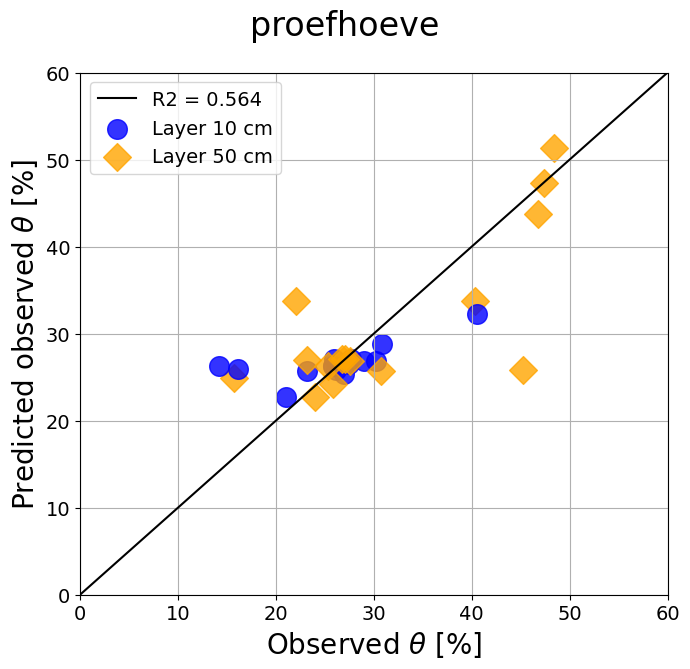

In [22]:
round_n = 3
target = 'vwc'

feature_10 = SR2_results[SR2_results['Target'] == 'vwc']['BestFeature10'].iloc[0]
feature_50 = SR2_results[SR2_results['Target'] == 'vwc']['BestFeature50'].iloc[0]

n_10 = Sresults[feature_10]['LS2']['n'][0]
n_50 = Sresults[feature_50]['LS2']['n'][1]

### Extract indices for 10 cm and 50 cm layers
idx_10 = ds[ds['depth'] == 10].index
idx_50 = ds[ds['depth'] == 50].index

### Select data at 10 cm depth
X_10 = ds.loc[idx_10, feature_10].values.reshape(-1, 1)
Y_10 = ds.loc[idx_10, target].values
### Select data at 50 cm depth
X_50 = ds.loc[idx_50, feature_50].values.reshape(-1, 1)
Y_50 = ds.loc[idx_50, target].values

#### Stochastic modelling for layers together
polySP_10 = PolynomialFeatures(degree=n_10)
polySP_10.fit(X_10)

Xt_10 = polySP_10.transform(X_10)
#Yt_10 = polySP_10.transform(Y_10)

LinRegSP = LinearRegression()
LinRegSP.fit(Xt_10, Y_10)
Ypred_10 = LinRegSP.predict(Xt_10)

#### Stochastic modelling for layers together
polySP_50 = PolynomialFeatures(degree=n_50)
polySP_50.fit(X_50)

Xt_50 = polySP_50.transform(X_50)

LinRegSP = LinearRegression()
LinRegSP.fit(Xt_50, Y_50)
Ypred_50 = LinRegSP.predict(Xt_50)

Y = np.concatenate((Y_10, Y_50))
Y_pred = np.concatenate((Ypred_10, Ypred_50))

r2 = round(r2_score(Y, Y_pred), round_n)

plot_stoch_implementation(ds, Y, Y_pred, r2, profile_prefix)